# **Modèle de scoring**

**Objectif :**
- sélectionner et évaluer des modèles de classification avec gestion du déséquilibre des classes et minimisation d'un coût métier 

In [5]:
import os
import time
import joblib
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  # utile si imbPipeline non utilisé

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    accuracy_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

from lightgbm import LGBMClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence

#  Affichage des versions
print("Versions utilisées :")
print(f"Python        : {os.sys.version.split()[0]}")
print(f"Numpy         : {np.__version__}")
print(f"Pandas        : {pd.__version__}")
print(f"Matplotlib    : {plt.matplotlib.__version__}")


C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versions utilisées :
Python        : 3.10.16
Numpy         : 2.2.5
Pandas        : 2.2.3
Matplotlib    : 3.10.1


In [7]:
df_train = pd.read_csv('app_train_filtered_final.csv')
df_test = pd.read_csv('app_test_filtered_final.csv')

In [8]:
display(df_train.shape)
display(df_train.head())

(307507, 75)

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,SECTOR_Medicine,SECTOR_Police,SECTOR_Other,OCCUPATION_Labor_Work,OCCUPATION_Sales_Services,OCCUPATION_Medical_Staff,OCCUPATION_Security,OCCUPATION_Management_Core,OCCUPATION_Other,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,False,False,True,False,False,False,False,False,1
1,100003,1,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,False,False,False,False,False,False,True,False,0
2,100004,0,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,True,False,False,False,False,False,0
3,100006,1,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,True,False,False,False,False,False,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,False,False,False,False,True,False,0


In [9]:
display(df_test.shape)
display(df_test.head())

(48744, 74)

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,SECTOR_Construction,SECTOR_Medicine,SECTOR_Police,SECTOR_Other,OCCUPATION_Labor_Work,OCCUPATION_Sales_Services,OCCUPATION_Medical_Staff,OCCUPATION_Security,OCCUPATION_Management_Core,OCCUPATION_Other
0,100001,1,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,False,False,False,False,False,False,False,False,False,True
1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,False,False,False,True,True,False,False,False,False,False
2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,False,False,False,False,True,False,False,False,False,False
3,100028,1,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,False,False,False,False,False,True,False,False,False,False
4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,False,False,False,False,False,False,False,False,False,True


## **Nettoyage et normalisation**

In [11]:
display(df_train.dtypes)

SK_ID_CURR                    int64
CODE_GENDER                   int64
FLAG_OWN_CAR                  int64
FLAG_OWN_REALTY               int64
CNT_CHILDREN                  int64
                              ...  
OCCUPATION_Medical_Staff       bool
OCCUPATION_Security            bool
OCCUPATION_Management_Core     bool
OCCUPATION_Other               bool
TARGET                        int64
Length: 75, dtype: object

In [12]:
pd.set_option('display.max_rows', None) 

# Vérifier les valeurs infinies et manquantes dans df_train
print("Vérification des valeurs manquantes et infinies dans df_train:")
print("NaN présents :")
print(df_train.isnull().mean())
print("Valeurs infinies présentes :")
print(np.isinf(df_train).mean())

# Remplacer les valeurs infinies par NaN
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Appliquer l'imputation (par exemple, remplacer les NaN par la médiane)
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputation sur df_train
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)

# Vérifier à nouveau les NaN et les infinies
print("\nAprès imputation :")
print(df_train_imputed.isnull().sum())
print(np.isinf(df_train_imputed).sum())


# Vérifier les valeurs infinies et manquantes dans df_train
print("Vérification des valeurs manquantes et infinies dans df_test:")
print("NaN présents :")
print(df_test.isnull().mean())
print("Valeurs infinies présentes :")
print(np.isinf(df_test).mean())

# Remplacer les valeurs infinies par NaN
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Appliquer l'imputation (par exemple, remplacer les NaN par la médiane)
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputation sur df_train
df_test_imputed = pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)

# Vérifier à nouveau les NaN et les infinies
print("\nAprès imputation :")
print(df_test_imputed.isnull().sum())
print(np.isinf(df_test_imputed).sum())



Vérification des valeurs manquantes et infinies dans df_train:
NaN présents :
SK_ID_CURR                                           0.000000
CODE_GENDER                                          0.000000
FLAG_OWN_CAR                                         0.000000
FLAG_OWN_REALTY                                      0.000000
CNT_CHILDREN                                         0.000000
AMT_INCOME_TOTAL                                     0.000000
AMT_CREDIT                                           0.000000
AMT_ANNUITY                                          0.000000
AMT_GOODS_PRICE                                      0.000000
REGION_POPULATION_RELATIVE                           0.000000
CNT_FAM_MEMBERS                                      0.000000
REGION_RATING_CLIENT_W_CITY                          0.000000
EXT_SOURCE_1                                         0.000000
EXT_SOURCE_2                                         0.000000
EXT_SOURCE_3                                         0

In [13]:
display(df_train.columns.tolist())

['SK_ID_CURR',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BUILD_AVG',
 'TOTALAREA_MODE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'IS_UNEMPLOYED',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'PREV_AMT_CREDIT_MAX',
 'PREV_AMT_APPLICATION_MEAN',
 'PREV_APP_CREDIT_PERC_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'POS_SK_DPD_MEAN',
 'POS_SK_DPD_DEF_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'INSTAL_PAYMENT_DIFF_MAX',
 'INSTAL_DPD_MEAN',
 'CC_AMT_BALANCE_MEAN',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN',
 'CC_SK_DPD_MAX',
 'DAYS_EMPLOYED_PERC',
 'INCOME_PER_PERSON',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'CREDIT_TERM',
 'AGE',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'NAME_INCOME_TYPE_Commercial associa

In [14]:
display(df_train_imputed.shape)

(307507, 75)

In [16]:
display(df_train_imputed.loc[df_train_imputed['TARGET']==1].head(100))

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,SECTOR_Medicine,SECTOR_Police,SECTOR_Other,OCCUPATION_Labor_Work,OCCUPATION_Sales_Services,OCCUPATION_Medical_Staff,OCCUPATION_Security,OCCUPATION_Management_Core,OCCUPATION_Other,TARGET
0,100002.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
26,100031.0,1.0,0.0,1.0,0.0,112500.0,979992.0,27076.5,702000.0,0.018029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
40,100047.0,0.0,0.0,1.0,0.0,202500.0,1193580.0,35028.0,855000.0,0.025164,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
42,100049.0,1.0,0.0,0.0,0.0,135000.0,288873.0,16258.5,238500.0,0.007305,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
81,100096.0,1.0,0.0,1.0,0.0,81000.0,252000.0,14593.5,252000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
94,100112.0,0.0,1.0,1.0,0.0,315000.0,953460.0,64107.0,900000.0,0.030755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
110,100130.0,1.0,0.0,1.0,1.0,157500.0,723996.0,30802.5,585000.0,0.007274,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
138,100160.0,0.0,0.0,1.0,0.0,292500.0,675000.0,36747.0,675000.0,0.035792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
154,100181.0,1.0,0.0,1.0,0.0,157500.0,245619.0,12667.5,166500.0,0.022625,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
163,100192.0,1.0,0.0,0.0,0.0,111915.0,225000.0,21037.5,225000.0,0.018801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [20]:
df_train_imputed.to_csv("../bdd/app_train_clean.csv", index=False)
df_test_imputed.to_csv("../bdd/app_test_clean.csv", index=False)

## **Déséquilibre des classes**

In [22]:
df_train_imputed['TARGET'].value_counts()

TARGET
0.0    282682
1.0     24825
Name: count, dtype: int64

0 : bons clients
1: mauvais clients

faux négatif: FN - mauvais client prédit bon client, crédit accordé et perte en capital
faux positif: FP - bon client prédit mauvais client, crédit refusé manque à gagner

**Rappel de la problématique :**

🟩Environ 92% des clients sont des "clients qui remboursent. En apprenant, le modèle va tout le temps prédire 0 puisque classe majoritaire. De plus, en terme de précision le modèle prédit toujours 0 il aura 92% d'accuracy ce qui est faux et problématique puisque le modèle n'arriverra pas à prédire les clients qui feront un défaut de paiement. 

🟧**De plus**, les clients "mauvais payeurs" mal détéctés (faux négatifs) ont un coût pour l'organisme de crédit beaucoup plus élevé qu'un faux positif. Un client "mauvais payeur" a qui ont accorde un crédit alors qu'il fera défaut coûte plus cher à l'organisme de crédit qu'un manque à gagner (client "bons payeurs" a qui ont n'accorde pas un crédit).

➡️**Méthode utilisée:**

💡 Utilisation de la technique de suréchantillonnage synthétiques des minorités (SMOTE)
- génère des données synthétiques pour la classe minoritaire.
- consiste à choisir aléatoirement un point de la classe minoritaire et à calculer les k plus proches voisins de ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.
- Inconvénient à prendre en compte: des exemples synthétiques sont créés sans tenir compte de la classe majoritaire, ce qui peut entraîner des exemples ambigus s’il existe un fort chevauchement entre les classes.
- SMOTE doit être utilisé en combinaison avec StratifiedKFold pour s'assurer que les proportions de classes sont respectées dans chaque fold, ce qui garantit que l'évaluation du modèle est fiable.
- 🔴SMOTE seulement sur les données d'entrainements et sur les folds d'entrainement pendant la cv pas sur la validation.🔴

💡 Utilisation de class_weighted en parallèle pour les modèles comme LogisticRegression, RF, Lightgbm etc.

💡 Utilisation de GridSearchCV et StratifiedKFold 

💡 Optimisation du seuil métier

💡 Métriques adaptées (ROC_AUC_score, precision, recall, f1_score, score métier)

In [28]:
# Exemple de SMOTE pour visualiser la différence de distribution de la TARGET 
df_train_final=df_train_imputed.copy()
df_test_final= df_test_imputed.copy()

# Diviser les données en train et test
X = df_train_final.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_train_final['TARGET']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Distribution avant SMOTE
print("Distribution de la target avant SMOTE :")
print(np.unique(y_train, return_counts=True))

# Appliquer SMOTE manuellement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Distribution après SMOTE
print("\nDistribution de la target après SMOTE :")
print(np.unique(y_train_smote, return_counts=True))

Distribution de la target avant SMOTE :
(array([0., 1.]), array([226145,  19860]))

Distribution de la target après SMOTE :
(array([0., 1.]), array([226145, 226145]))


## **Modèles de classification**

**Méthode utilisée**

1. Création des jeux de données (train 80%, test et val 20%)
2. Normalisation est appliquée uniquement pour les modèles sensibles aux échelles (Logistic Regression et Naive Bayes).
3. SMOTE est utilisé uniquement sur le jeu d'entraînement pour corriger le déséquilibre, mais hors pipeline, car inclus dans une grille rend le temps de calcul trop élevé.
4. Sélection de 3 modèles avec pondération automatique des classes (class_weight='balanced'): Logistic Regression, Naive Bayes, et RandomForest
5. Définition des grilles d'hyperparamètres pour chacun des modèles afin d'optimiser leurs performances.
6. BayesSearchCV avec Cross-Validation: 3-fold Stratifié sur l'entraînement uniquement pour sélectionner les meilleurs hyperparamètres.
7. Évaluation sur Validation : calcul des principales métriques (f1, precision, recall, ROC AUC) sur des données jamais vues.
8. Optimisation du seuil de classification : recherche du meilleur seuil pour minimiser un coût métier (10×FN + 1×FP)
9. Comparaison finale : agrégation de toutes les métriques et sélection du modèle optimal pour prédiction sur les données de test (val).

In [32]:
# Identifier les features numériques continues
numerical_features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS','CNT_CHILDREN',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'BURO_DAYS_CREDIT_MEAN', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'BURO_CREDIT_DAY_OVERDUE_MEAN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_APPLICATION_MEAN', 'PREV_APP_CREDIT_PERC_MEAN',
    'PREV_DAYS_DECISION_MIN', 'POS_SK_DPD_MEAN', 'POS_SK_DPD_DEF_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN', 'INSTAL_PAYMENT_DIFF_MAX',
    'INSTAL_DPD_MEAN', 'CC_AMT_BALANCE_MEAN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN', 'CC_SK_DPD_MAX', 'DAYS_EMPLOYED_PERC',
    'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'CREDIT_TERM', 'AGE']


## 1. Split + Normlisation 

In [34]:
# Modèles sans besoin de normaliser (LightGBM et RF)
X_base = df_train_final.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df_train_final['TARGET']
X_test_base = df_test_final.drop(columns=['SK_ID_CURR'])

X_train_base, X_val_base, y_train_split, y_val_split = train_test_split(X_base, y, test_size=0.2, stratify=y, random_state=42)

print(f"🔹Shape X_train_base : {X_train_base.shape}")
print(f"🔹Shape X_val_base : {X_val_base.shape}")
print(f"🔹Shape y_train_split : {y_train_split.shape}")
print(f"🔹Shape y_val_split : {y_val_split.shape}")
print(f"🔹Shape de X_test_base: {X_test_base.shape}")

# Modèles qui ont besoin de normalisation (logisticregression et SVM)
scaler = StandardScaler()
scaler.fit(X_base[numerical_features])

X_scaled = X_base.copy()
X_scaled[numerical_features] = scaler.transform(X_scaled[numerical_features])

X_test_scaled = X_test_base.copy()
X_test_scaled[numerical_features] = scaler.transform(X_test_scaled[numerical_features])

X_train_scaled, X_val_scaled, y_train_split, y_val_split= train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

print(f"🔹Shape X_train_scaled : {X_train_scaled.shape}")
print(f"🔹Shape X_val_scaled : {X_val_scaled.shape}")
print(f"🔹Shape y_train_split : {y_train_split.shape}")
print(f"🔹Shape y_val_split : {y_val_split.shape}")
print(f"🔹Shape de X_test_scaled: {X_test_scaled.shape}")


# Sauvegarde des jeux de données nécessaires
joblib.dump(X_val_scaled, "../data/X_val_scaled.pkl")
joblib.dump(X_val_base, "../data/X_val_base.pkl")
joblib.dump(y_val_split, "../data/y_val_split.pkl")
joblib.dump(X_test_scaled, "../data/X_test_scaled.pkl")
joblib.dump(X_test_base, "../data/X_test_base.pkl")

🔹Shape X_train_base : (246005, 73)
🔹Shape X_val_base : (61502, 73)
🔹Shape y_train_split : (246005,)
🔹Shape y_val_split : (61502,)
🔹Shape de X_test_base: (48744, 73)
🔹Shape X_train_scaled : (246005, 73)
🔹Shape X_val_scaled : (61502, 73)
🔹Shape y_train_split : (246005,)
🔹Shape y_val_split : (61502,)
🔹Shape de X_test_scaled: (48744, 73)


['../data/X_test_base.pkl']

In [35]:
display(X_base.dtypes)

CODE_GENDER                                          float64
FLAG_OWN_CAR                                         float64
FLAG_OWN_REALTY                                      float64
CNT_CHILDREN                                         float64
AMT_INCOME_TOTAL                                     float64
AMT_CREDIT                                           float64
AMT_ANNUITY                                          float64
AMT_GOODS_PRICE                                      float64
REGION_POPULATION_RELATIVE                           float64
CNT_FAM_MEMBERS                                      float64
REGION_RATING_CLIENT_W_CITY                          float64
EXT_SOURCE_1                                         float64
EXT_SOURCE_2                                         float64
EXT_SOURCE_3                                         float64
YEARS_BUILD_AVG                                      float64
TOTALAREA_MODE                                       float64
DEF_60_CNT_SOCIAL_CIRCLE

**Courbe ROC**: représentation graphique utilisée pour évaluer la performance d’un modèle de classification, notamment dans les situations de classes déséquilibrées. Elle trace la relation entre les vrais positifs et les faux positifs à différents seuils de classification.
- Abcisses : Taux de faux positif -> mauvais client classé en bon client
- Ordonnées: Taux de vrai positif -> bons clients classé en bon (recall)

**AUC**: Aire sous la courbe, si = 1 classificateur parfait, si proche de 0.5 alors aléatoire.

## 2. Fonctions communes

In [38]:
def evaluate_model(y_true, y_pred, y_proba, threshold=0.5):
    """
    Affiche les métriques principales d'évaluation du modèle et les retourne sous forme de dictionnaire.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10 * fn + 1 * fp
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    accuracy = accuracy_score(y_true, y_pred)

    print(f"\n🔎 Seuil appliqué : {threshold:.2f}")
    print(f"🎯 Coût métier = {cost}")
    print(f"✅ F1-score = {f1:.4f}")
    print(f"✅ Précision = {precision:.4f}")
    print(f"✅ Rappel = {recall:.4f}")
    print(f"✅ ROC AUC = {roc_auc:.4f}")
    print(f"✅ Accuracy = {accuracy:.4f}")
    print(pd.Series(y_pred).value_counts())

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title("Matrice de confusion")
    plt.show()

    return {
        "ROC_AUC": roc_auc,
        "Cost": cost,
        "F1_Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy
    }


def find_optimal_threshold(y_true, y_proba, cost_fn_weight=10, cost_fp_weight=1, step=0.05):
    """
    Trouve le seuil qui minimise le coût métier défini.
    """
    thresholds = np.arange(0.05, 1.0, step)
    best_threshold = 0.5
    best_cost = float("inf")

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = cost_fn_weight * fn + cost_fp_weight * fp
        if cost < best_cost:
            best_cost = cost
            best_threshold = t

    return best_threshold

In [39]:
def plot_roc(y_true, y_proba, label=None):
    """
    Affiche la courbe ROC 
    (vrais positifs: mauvais clients dans mauvais/ faux positifs: bons clients dans mauvais)
    """
    
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    plt.plot(fpr, tpr, lw=2, label=f"{label or 'ROC'} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid(True)
    plt.show()


## 3. Naives Bayes (modèle simple de base)

Utilisation de GaussianNB car attend de features numériques continues(normalement pour variable OHE BernoulliNB, mais puisque plus de variables continues numériques reste sur GaussianNB)

⏱️ Temps d'entraînement ROC AUC : 0.92s

🔎 Seuil appliqué : 0.50
🎯 Coût métier = 41986
✅ F1-score = 0.1977
✅ Précision = 0.1178
✅ Rappel = 0.6143
✅ ROC AUC = 0.6429
0    35616
1    25886
Name: count, dtype: int64


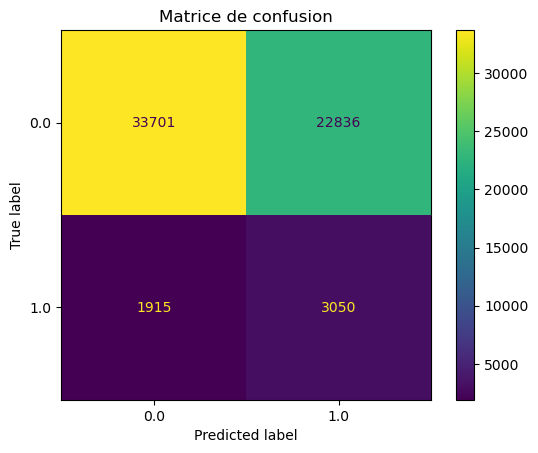


🔎 Seuil appliqué : 0.85
🎯 Coût métier = 40924
✅ F1-score = 0.2098
✅ Précision = 0.1316
✅ Rappel = 0.5166
✅ ROC AUC = 0.6429
0    42013
1    19489
Name: count, dtype: int64


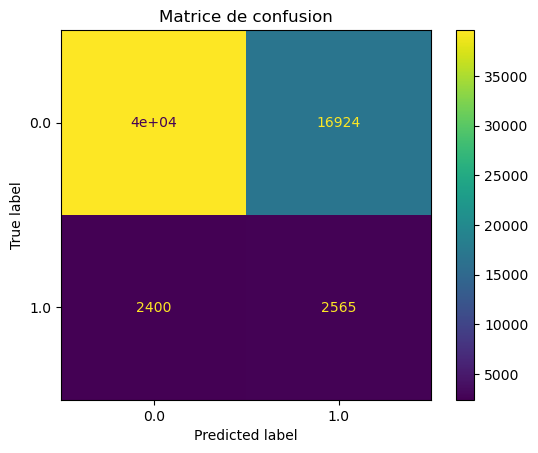

['data/y_val_pred_gnb.pkl']

In [157]:
# 1. SMOTE sur données normalisées
X_train_norm, y_train_norm = smote.fit_resample(X_train_scaled, y_train_split)

# 2. BayesSearchCV ROC AUC

start_time = time.time()
gnb_model = GaussianNB()
gnb_model.fit(X_train_norm, y_train_norm)
execution_time = time.time() - start_time

print(f"⏱️ Temps d'entraînement ROC AUC : {execution_time:.2f}s")

# 3. Évaluation
y_val_proba_gnb = gnb_model.predict_proba(X_val_scaled)[:, 1]

# Prédictions au seuil 0.50 (standard)
y_val_pred_050_gnb = (y_val_proba_gnb >= 0.5).astype(int) # mon .predict manuel
evaluate_model(y_val_split, y_val_pred_050_gnb, y_val_proba_gnb, threshold=0.5)

# Recherche du seuil optimal
threshold_opt_gnb = find_optimal_threshold(y_val_split, y_val_proba_gnb)

# Prédictions au seuil optimal
y_val_pred_gnb = (y_val_proba_gnb >= threshold_opt_gnb).astype(int)
metrics_gnb = evaluate_model(y_val_split, y_val_pred_gnb, y_val_proba_gnb, threshold=threshold_opt_gnb)

# Sauvegarde du modèle
joblib.dump(gnb_model, "../model/best_model_gnb.pkl")
joblib.dump(y_val_proba_gnb, "../data/y_val_proba_gnb.pkl")
joblib.dump(y_val_pred_050_gnb, "../data/y_val_pred_050_gnb.pkl")
joblib.dump(threshold_opt_gnb, "../data/threshold_opt_gnb.pkl")
joblib.dump(y_val_pred_gnb, "../data/y_val_pred_gnb.pkl")

In [213]:
joblib.dump(metrics_gnb, "../model/metrics_gnb.pkl")

['model/metrics_gnb.pkl']

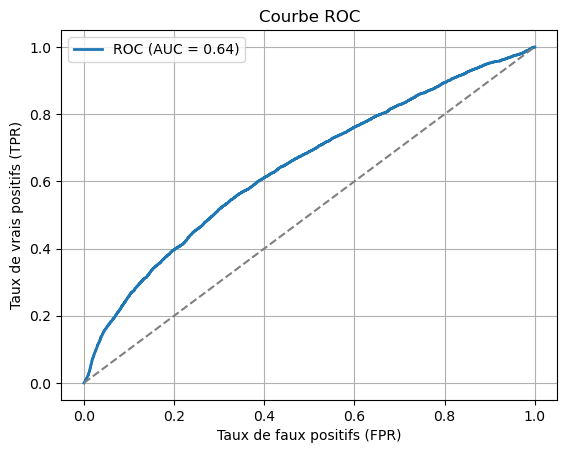

In [158]:
plot_roc(y_val_split, y_val_proba_gnb)

- Très rapide à entraîner
- Précision très faible (0.13) → beaucoup de faux positifs (on prédit que le client est à risque alors qu’il ne l’est pas).
- Rappel élevé (0.52) → détecte plus de mauvais payeurs, mais au prix d’un grand nombre de bons clients mal classés.
- un seuil optimal élevé (0.85) rend le modèle beaucoup plus laxiste : un client est considéré comme bon s’il a au moins 15 % de chance d’être bon payeur. Cela augmente l’acceptation de clients, mais au prix d’un risque accru.
- Coût métier élevé

## 4. Logistic Regression

C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


⏱️ Temps d'entraînement ROC AUC : 2722.53s
✔️ Meilleurs paramètres : OrderedDict([('C', 0.4999626979766749), ('penalty', 'l2')])

🔎 Seuil appliqué : 0.50
🎯 Coût métier = 33549
✅ F1-score = 0.2617
✅ Précision = 0.1627
✅ Rappel = 0.6681
✅ ROC AUC = 0.7430
0    41116
1    20386
Name: count, dtype: int64


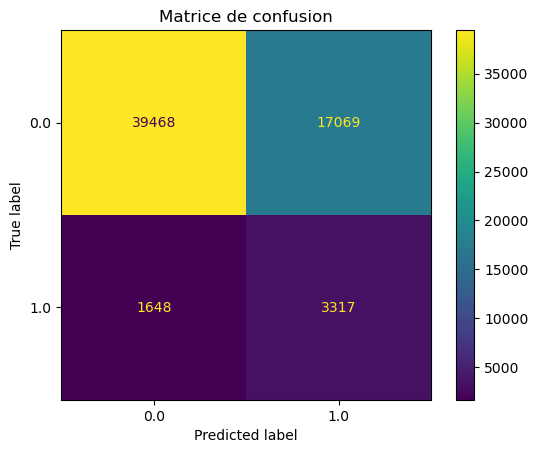


🔎 Seuil appliqué : 0.50
🎯 Coût métier = 33549
✅ F1-score = 0.2617
✅ Précision = 0.1627
✅ Rappel = 0.6681
✅ ROC AUC = 0.7430
0    41116
1    20386
Name: count, dtype: int64


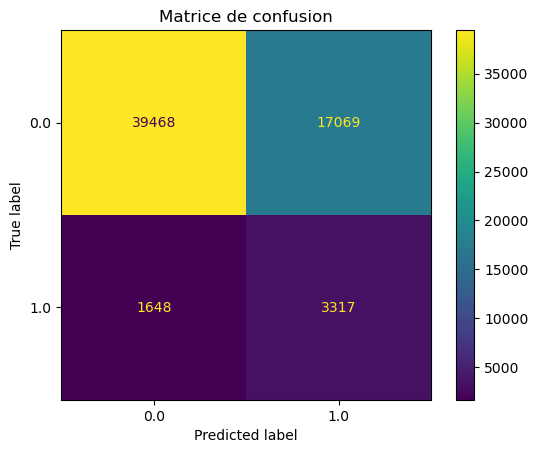

['data/y_val_pred_opt_lr.pkl']

In [175]:
# 1. SMOTE sur données normalisées
X_train_norm, y_train_norm = smote.fit_resample(X_train_scaled, y_train_split)

# 2. BayesSearchCV ROC AUC
lr_model = LogisticRegression(class_weight='balanced', solver='saga', random_state=42)

search_space_lr = {
    'C': Real(0.1, 0.5),
    'penalty': Categorical(['l2'])
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
opt_lr = BayesSearchCV(
    estimator=lr_model,
    search_spaces=search_space_lr,
    scoring='roc_auc',
    cv=cv,
    n_iter=30,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

start_time = time.time()
opt_lr.fit(X_train_norm, y_train_norm)
execution_time = time.time() - start_time

print(f"⏱️ Temps d'entraînement ROC AUC : {execution_time:.2f}s")
print(f"✔️ Meilleurs paramètres : {opt_lr.best_params_}")

# 3. Évaluation
best_model_lr = opt_lr.best_estimator_
y_val_proba_lr = best_model_lr.predict_proba(X_val_scaled)[:, 1]

# Prédictions au seuil 0.50 (standard)
y_val_pred_050_lr = (y_val_proba_lr >= 0.5).astype(int)
evaluate_model(y_val_split, y_val_pred_050_lr, y_val_proba_lr, threshold=0.5)

# Recherche du seuil optimal
threshold_opt_lr = find_optimal_threshold(y_val_split, y_val_proba_lr)

# Prédictions au seuil optimal
y_val_pred_opt_lr = (y_val_proba_lr >= threshold_opt_lr).astype(int)
metrics_lr = evaluate_model(y_val_split, y_val_pred_opt_lr, y_val_proba_lr, threshold=threshold_opt_lr)

# Sauvegarde du modèle
joblib.dump(best_model_lr, "../model/best_model_lr.pkl")
joblib.dump(y_val_proba_lr, "../data/y_val_proba_lr.pkl")
joblib.dump(y_val_pred_050_lr, "../data/y_val_pred_050_lr.pkl")
joblib.dump(threshold_opt_lr, "../data/threshold_opt_lr.pkl")
joblib.dump(y_val_pred_opt_lr, "../data/y_val_pred_opt_lr.pkl")

In [215]:
joblib.dump(metrics_lr, "../model/metrics_lr.pkl")

['model/metrics_lr.pkl']

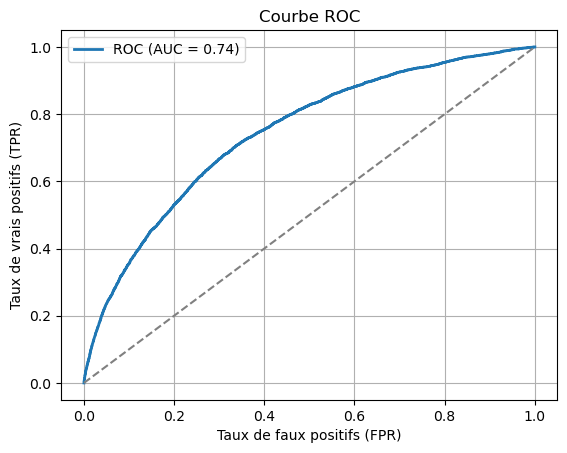

In [176]:
plot_roc(y_val_split, y_val_proba_lr)

-  Bon compromis précision/rappel.
-  Meilleur rappel (0.668) de tous les modèles
-  Coût métier à 33 549, donc très compétitif, bien que légèrement moins bon que LightGBM.
-  Très interprétable : chaque coefficient peut être expliqué simplement au métier ("si salaire augmente, risque baisse").
-  Temps d’entraînement très long (plus de 45 minutes)
-  Optimisation du seuil inchangé = 0.50

## 5. LightGBM

⏱️ Temps d'entraînement ROC AUC : 657.45s
✔️ Meilleurs paramètres : OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.11114350653481823), ('max_depth', 12), ('min_child_samples', 100), ('num_leaves', 150), ('reg_alpha', 1.0), ('reg_lambda', 1.0), ('scale_pos_weight', 1), ('subsample', 0.5)])

🔎 Seuil appliqué : 0.50
🎯 Coût métier = 48143
✅ F1-score = 0.0621
✅ Précision = 0.5699
✅ Rappel = 0.0328
✅ ROC AUC = 0.7718
0    61216
1      286
Name: count, dtype: int64


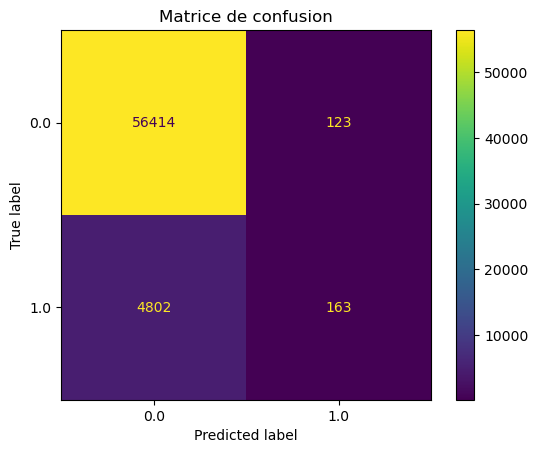


🔎 Seuil appliqué : 0.10
🎯 Coût métier = 31227
✅ F1-score = 0.2950
✅ Précision = 0.1915
✅ Rappel = 0.6421
✅ ROC AUC = 0.7718
0    44857
1    16645
Name: count, dtype: int64


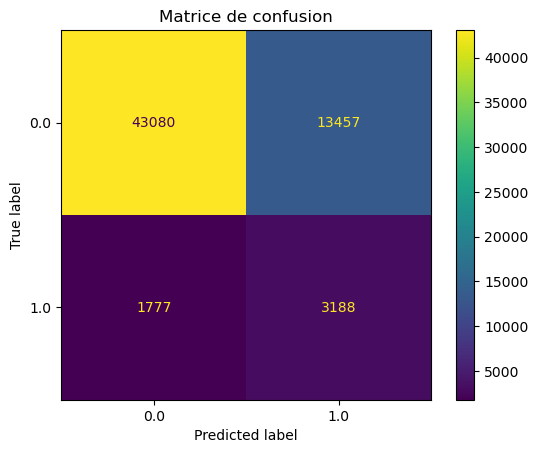

['data/y_val_pred_opt.pkl']

In [179]:
# 1. SMOTE sur données non normalisées
X_train_smote, y_train_smote = smote.fit_resample(X_train_base, y_train_split)

# 2. BayesSearchCV ROC AUC
lgbm_model = LGBMClassifier(objective='binary', class_weight='balanced', random_state=42, verbose=-1, n_jobs=-1)
search_space = {
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'num_leaves': Integer(15, 150),
    'max_depth': Integer(3, 12),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(1e-3, 1.0, prior='log-uniform'),
    'reg_lambda': Real(1e-3, 1.0, prior='log-uniform'),
    'scale_pos_weight': Integer(1, 20)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
opt = BayesSearchCV(
    estimator=lgbm_model,
    search_spaces=search_space,
    scoring='roc_auc',
    cv=cv,
    n_iter=30,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

start_time = time.time()
opt.fit(X_train_smote, y_train_smote)
execution_time = time.time() - start_time

print(f"⏱️ Temps d'entraînement ROC AUC : {execution_time:.2f}s")
print(f"✔️ Meilleurs paramètres : {opt.best_params_}")

# 3. Évaluation
best_model = opt.best_estimator_
y_val_proba = best_model.predict_proba(X_val_base)[:, 1]

# Prédictions au seuil 0.50 (standard)
y_val_pred_050 = (y_val_proba >= 0.5).astype(int)
evaluate_model(y_val_split, y_val_pred_050, y_val_proba, threshold=0.5)

# Recherche du seuil optimal
threshold_opt = find_optimal_threshold(y_val_split, y_val_proba)

# Prédictions au seuil optimal
y_val_pred_opt = (y_val_proba >= threshold_opt).astype(int)
metrics_lgbm = evaluate_model(y_val_split, y_val_pred_opt, y_val_proba, threshold=threshold_opt)

# Sauvegarde du modèle
joblib.dump(best_model, "../model/best_model_lightgbm.pkl")
joblib.dump(y_val_proba, "../data/y_val_proba.pkl")
joblib.dump(y_val_pred_050, "../data/y_val_pred_050.pkl")
joblib.dump(threshold_opt, "../data/threshold_opt.pkl")
joblib.dump(y_val_pred_opt, "../data/y_val_pred_opt.pkl")

In [217]:
joblib.dump(metrics_lgbm, "../model/metrics_lgbm.pkl")

['model/metrics_lgbm.pkl']

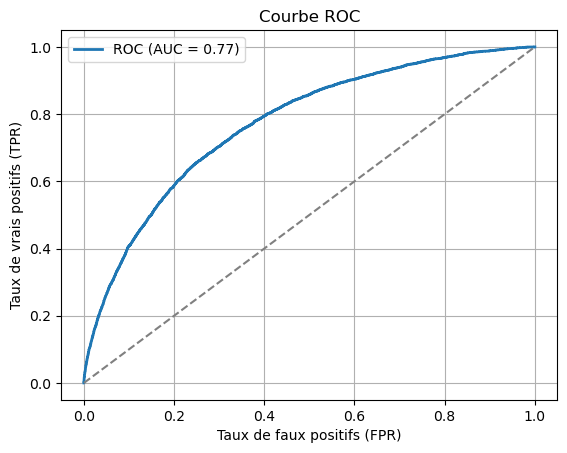

In [180]:
plot_roc(y_val_split, y_val_proba)

Modèle le plus équilibré :
- Très bon F1-score (0.295) : équilibre entre faux positifs et faux négatifs.
- Précision (0.192) correcte → moins de rejet abusif de bons clients.
- Rappel (0.64) élevé → bon taux de détection des mauvais clients.
- Coût métier le plus bas (31 227) → meilleur choix économique.
- Temps d’entraînement raisonnable (~10 min)
- minimiser les pertes globales (coût métier)
- Seuil optimisé très stricte à 0.10: le modèle classifie les bons clients en bon seulement s'ils ont 90% de proba d'être un bon client

## 6. Random Forest

⏱️ Temps d'entraînement ROC AUC : 10356.44s
✔️ Meilleurs paramètres : OrderedDict([('max_depth', 27), ('max_features', 'log2'), ('min_samples_split', 4), ('n_estimators', 759)])

🔎 Seuil appliqué : 0.50
🎯 Coût métier = 48143
✅ F1-score = 0.0621
✅ Précision = 0.5699
✅ Rappel = 0.0328
✅ ROC AUC = 0.7718
0    61216
1      286
Name: count, dtype: int64


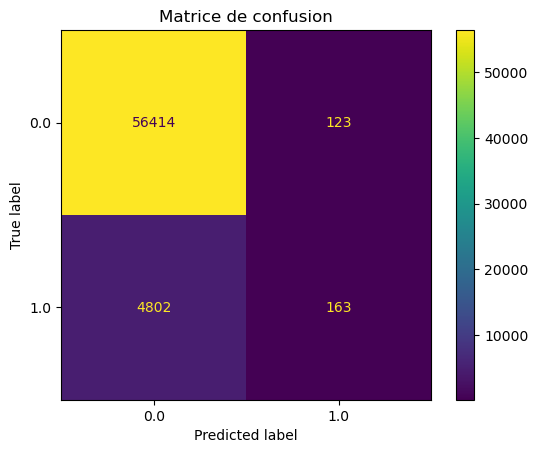


🔎 Seuil appliqué : 0.10
🎯 Coût métier = 31227
✅ F1-score = 0.2950
✅ Précision = 0.1915
✅ Rappel = 0.6421
✅ ROC AUC = 0.7718
0    44857
1    16645
Name: count, dtype: int64


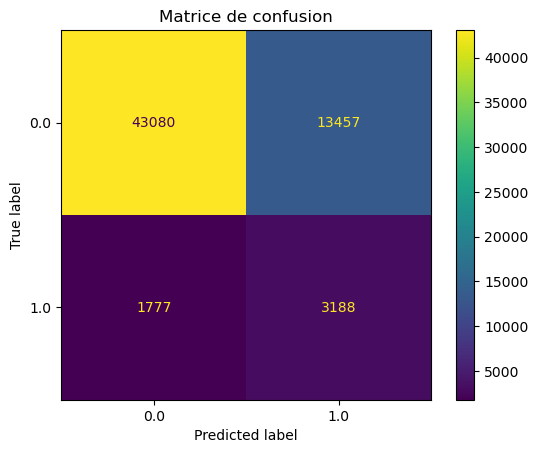

['data/y_val_pred_opt_rf.pkl']

In [183]:
# 1. SMOTE sur données non normalisées
X_train_smote, y_train_smote = smote.fit_resample(X_train_base, y_train_split)

# 2. BayesSearchCV ROC AUC
rf_model =  RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

search_space_rf = {
    'n_estimators': Integer(750, 800),
    'max_depth': Integer(20, 30),
    'min_samples_split': Integer(4, 6),
    'max_features': Categorical(['log2'])
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

opt_rf = BayesSearchCV(
    estimator=rf_model,
    search_spaces=search_space_rf,
    scoring='roc_auc',
    cv=cv,
    n_iter=10,  
    n_jobs=-1,
    random_state=42,
    verbose=0
)

start_time = time.time()
opt_rf.fit(X_train_smote, y_train_smote)
execution_time = time.time() - start_time

print(f"⏱️ Temps d'entraînement ROC AUC : {execution_time:.2f}s")
print(f"✔️ Meilleurs paramètres : {opt_rf.best_params_}")

# 3. Évaluation
best_model_rf = opt_rf.best_estimator_
y_val_proba_rf = best_model.predict_proba(X_val_base)[:, 1]

# Prédictions au seuil 0.50 (standard)
y_val_pred_rf_050 = (y_val_proba_rf >= 0.5).astype(int)
evaluate_model(y_val_split, y_val_pred_rf_050, y_val_proba_rf, threshold=0.5)

# Recherche du seuil optimal
threshold_opt_rf = find_optimal_threshold(y_val_split, y_val_proba_rf)

# Prédictions au seuil optimal
y_val_pred_opt_rf = (y_val_proba_rf >= threshold_opt_rf).astype(int)
metrics_rf = evaluate_model(y_val_split, y_val_pred_opt_rf, y_val_proba_rf, threshold=threshold_opt_rf)

# Sauvegarde du modèle

joblib.dump(best_model_rf, "../model/best_model_rf.pkl")
joblib.dump(y_val_proba_rf, "../data/y_val_proba_rf.pkl")
joblib.dump(y_val_pred_rf_050, "../data/y_val_pred_rf_050.pkl")
joblib.dump(threshold_opt_rf, "../data/threshold_opt_rf.pkl")
joblib.dump(y_val_pred_opt_rf, "../data/y_val_pred_opt_rf.pkl")

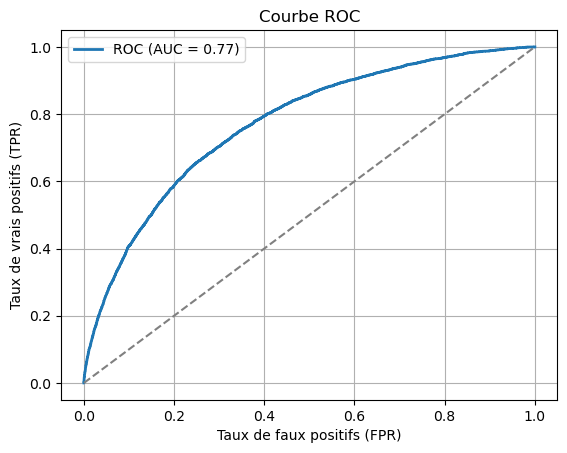

In [185]:
plot_roc(y_val_split, y_val_proba_rf)

In [219]:
joblib.dump(metrics_rf, "../model/metrics_rf.pkl")

['model/metrics_rf.pkl']

- Même performance que LightGBM (F1, précision, rappel, coût).
- Temps d’entraînement 10× plus long que LightGBM

In [188]:
# Résultats pour seuil = 0.50
results_threshold_050 = pd.DataFrame([
    {"Modèle": "Naive Bayes", "Seuil": 0.50, "Coût métier": 41986, "F1-score": 0.1977, "Précision": 0.1178, "Rappel": 0.6143, "ROC AUC": 0.6429},
    {"Modèle": "Logistic Regression", "Seuil": 0.50, "Coût métier": 33549, "F1-score": 0.2617, "Précision": 0.1627, "Rappel": 0.6681, "ROC AUC": 0.7430},
    {"Modèle": "LightGBM", "Seuil": 0.50, "Coût métier": 48143, "F1-score": 0.0621, "Précision": 0.5699, "Rappel": 0.0328, "ROC AUC": 0.7718},
    {"Modèle": "Random Forest", "Seuil": 0.50, "Coût métier": 48143, "F1-score": 0.0621, "Précision": 0.5699, "Rappel": 0.0328, "ROC AUC": 0.7718}
])

# Résultats pour le seuil optimisé
results_threshold_opt = pd.DataFrame([
    {"Modèle": "Naive Bayes", "Seuil": 0.85, "Coût métier": 40924, "F1-score": 0.2098, "Précision": 0.1316, "Rappel": 0.5166, "ROC AUC": 0.6429},
    {"Modèle": "Logistic Regression", "Seuil": 0.50, "Coût métier": 33549, "F1-score": 0.2617, "Précision": 0.1627, "Rappel": 0.6681, "ROC AUC": 0.7430},
    {"Modèle": "LightGBM", "Seuil": 0.10, "Coût métier": 31227, "F1-score": 0.2950, "Précision": 0.1915, "Rappel": 0.6421, "ROC AUC": 0.7718},
    {"Modèle": "Random Forest", "Seuil": 0.10, "Coût métier": 31227, "F1-score": 0.2950, "Précision": 0.1915, "Rappel": 0.6421, "ROC AUC": 0.7718}
])

# Affichage
print("📊 Résultats au seuil = 0.50")
display(results_threshold_050)

print("\n📊 Résultats au seuil optimisé")
display(results_threshold_opt)


📊 Résultats au seuil = 0.50


,Modèle,Seuil,Coût métier,F1-score,Précision,Rappel,ROC AUC
0,Naive Bayes,0.5,41986,0.1977,0.1178,0.6143,0.6429
1,Logistic Regression,0.5,33549,0.2617,0.1627,0.6681,0.7430
2,LightGBM,0.5,48143,0.0621,0.5699,0.0328,0.7718
3,Random Forest,0.5,48143,0.0621,0.5699,0.0328,0.7718



📊 Résultats au seuil optimisé


,Modèle,Seuil,Coût métier,F1-score,Précision,Rappel,ROC AUC
0,Naive Bayes,0.85,40924,0.2098,0.1316,0.5166,0.6429
1,Logistic Regression,0.50,33549,0.2617,0.1627,0.6681,0.7430
2,LightGBM,0.10,31227,0.2950,0.1915,0.6421,0.7718
3,Random Forest,0.10,31227,0.2950,0.1915,0.6421,0.7718


Meilleur modèle est LightGBM : équilibre entre temps d'exécution, faible coût métier, équilibre F1 score (précision et rappel) , et bon rappel. 

## **Exécution sur tout le train et prédiction sur le test**

#### LightGBM

In [193]:
import pickle

# 1. Définir et entraîner le modèle LightGBM avec les meilleurs hyperparamètres
final_model = LGBMClassifier(
    colsample_bytree= 0.5,
    learning_rate=0.11114350653481823,
    max_depth=12,
    min_child_samples= 100,
    n_estimators=300,
    num_leaves=150,
    reg_alpha=1.0,
    reg_lambda=1.0,
    scale_pos_weight=1,
    subsample=0.5,
    class_weight='balanced',
    random_state=42
)

# Entraînement sur tout le dataset d'entraînement (X, y)
final_model.fit(X_base, y)

# 2. Sauvegarde du modèle final
with open('final_model_lightgbm.pkl', 'wb') as file:
    pickle.dump(final_model, file)

print("✅ Modèle LightGBM final entraîné et sauvegardé.")


✅ Modèle LightGBM final entraîné et sauvegardé.


✅ Prédictions terminées avec seuil 0.10
Nombre de clients classés par le modèle :
1    35087
0    13657
Name: count, dtype: int64


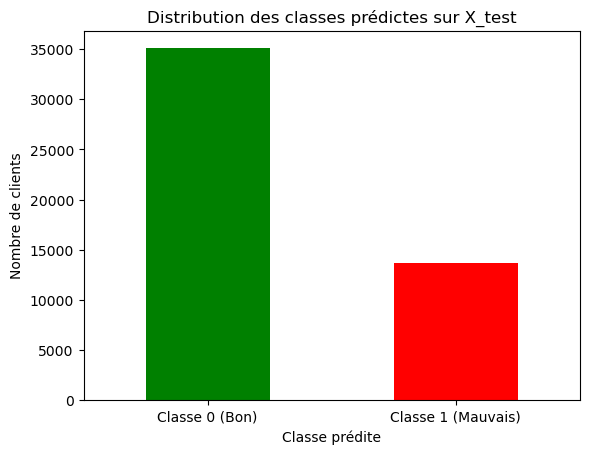

['data/y_test_pred_final.pkl']

In [194]:
# 3. Prédictions de probabilités
y_test_proba = final_model.predict_proba(X_test_base)[:, 1]

# 4. Application du seuil optimisé
threshold = 0.10
y_test_pred = (y_test_proba >= threshold).astype(int)

print("✅ Prédictions terminées avec seuil 0.10")
# Compter
counts = pd.Series(y_test_pred).value_counts()
print("Nombre de clients classés par le modèle :")
print(counts)

# Visualisation rapide
counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution des classes prédictes sur X_test')
plt.xlabel('Classe prédite')
plt.ylabel('Nombre de clients')
plt.xticks(ticks=[0, 1], labels=["Classe 0 (Bon)", "Classe 1 (Mauvais)"], rotation=0)
plt.show()

joblib.dump(final_model, "../model/final_model_lgbm.pkl")
joblib.dump(y_test_proba, "../data/y_test_proba_final.pkl")
joblib.dump(y_test_pred, "../data/y_test_pred_final.pkl")

- Le modèle best_model_lightgbm.pkl  est un modèle entraîné sur un split (X_train_split) uniquement. (80%)
- Le modèle final_model_lightgbm.pkl sera donc plus fort et plus fiable car entraîné sur toutes les données d'entraînement. (100%)

## **Feature Importance sur les vraies prédictions**

### **Globale**

**feature_importances_ de LightGBM**
- méthode utilise les informations internes du modèle comme le nombre de fois qu'une feature est utilisée pour faire une séparation dans les arbres.
- Ne tient pas compte des interactions complexes entre les features.
- Elle ne mesure pas l'effet réel d'une variable sur la prédiction, seulement sa fréquence d'utilisation.

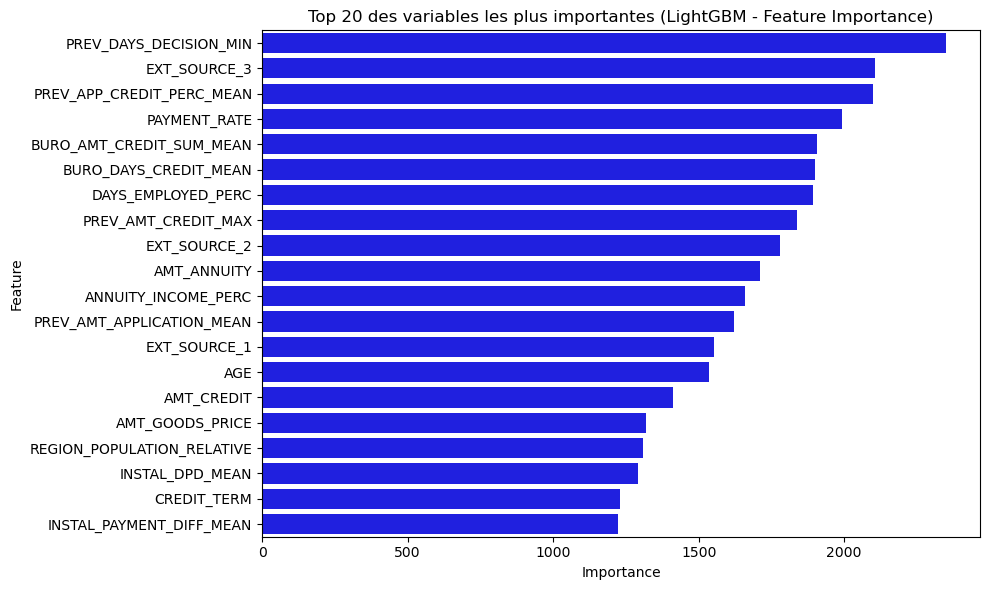

In [199]:
importances = final_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', color='blue')
plt.title("Top 20 des variables les plus importantes (LightGBM - Feature Importance)")
plt.tight_layout()
plt.show()

Les variables les plus utilisées / influentes pour la construction des arbres sont :

- PREV_DAYS_DECISION_MIN, EXT_SOURCE_3, PREV_APP_CREDIT_PERC_MEAN

Beaucoup de variables liées à l’historique de crédit (PREV_, BURO_, PAYMENT_RATE) sont présentes.
Il mesure combien de fois une feature a été utilisée dans les arbres, ne mesure pas l’impact concret sur les prédictions finales.

**SHAP**:
- théorie des jeux de Shapley pour attribuer à chaque feature une contribution moyenne pondérée sur toutes les prédictions.
- Calcule pour chaque feature combien elle contribue à augmenter ou baisser la prédiction du modèle
- Prend en compte les interactions entre variables.
- Plus coûteux en exécution
- Plus performant avec des dataframe volumineuse comme ici


C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


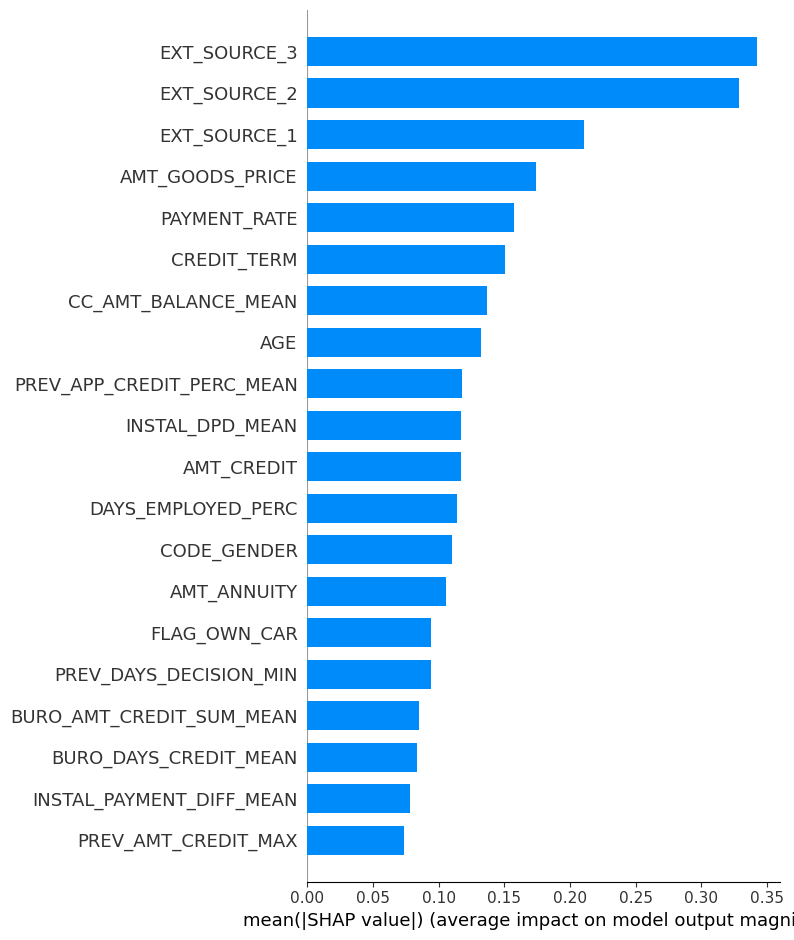

In [202]:
# Résumé global
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_base)

# Si shap_values est une liste (binaire), on prend classe 1
if isinstance(shap_values, list):
    shap_values_to_use = shap_values[1]
    base_value = explainer.expected_value[1]
else:
    shap_values_to_use = shap_values
    base_value = explainer.expected_value

# Summary plot global
shap.summary_plot(shap_values_to_use, X_test_base, plot_type="bar", max_display=20)


- Payment_Rate = taux de remboursement, annuité/crédit total = calcule la rapidité à laquelle le client rembourse son crédit
- Notation extérieure sur le risque du client
- Prix du bien 
- Credit term: Durée de remboursement du crédit (en années)


Les variables EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1 dominent très nettement.
- AMT_GOODS_PRICE, PAYMENT_RATE, CREDIT_TERM suivent.
- Moins de variables PREV_ et BURO_ que dans le graphique précédent.
- Les variables EXT_SOURCE_x: scores externes d’évaluation du risque ; très fiables car synthétiques.
- PAYMENT_RATE (taux de remboursement) est logiquement critique : plus il est élevé, plus le client semble solvable.
- AGE, AMT_ANNUITY, CREDIT_TERM sont également intuitifs.

### **Locale**

Client sélectionné : 10


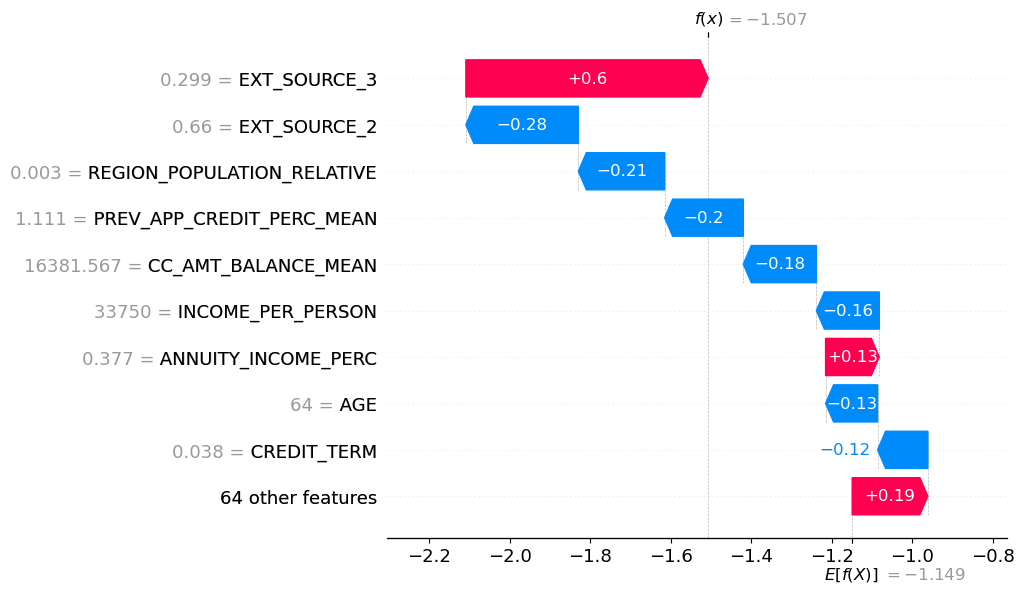

In [205]:
# Sélection d’un client
indice_client = 10
print(f"Client sélectionné : {indice_client}")
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_to_use[indice_client],
        base_values=base_value,
        data=X_test_base.iloc[indice_client],
        feature_names=X_test_base.columns
    )
)


Client sélectionné : 458


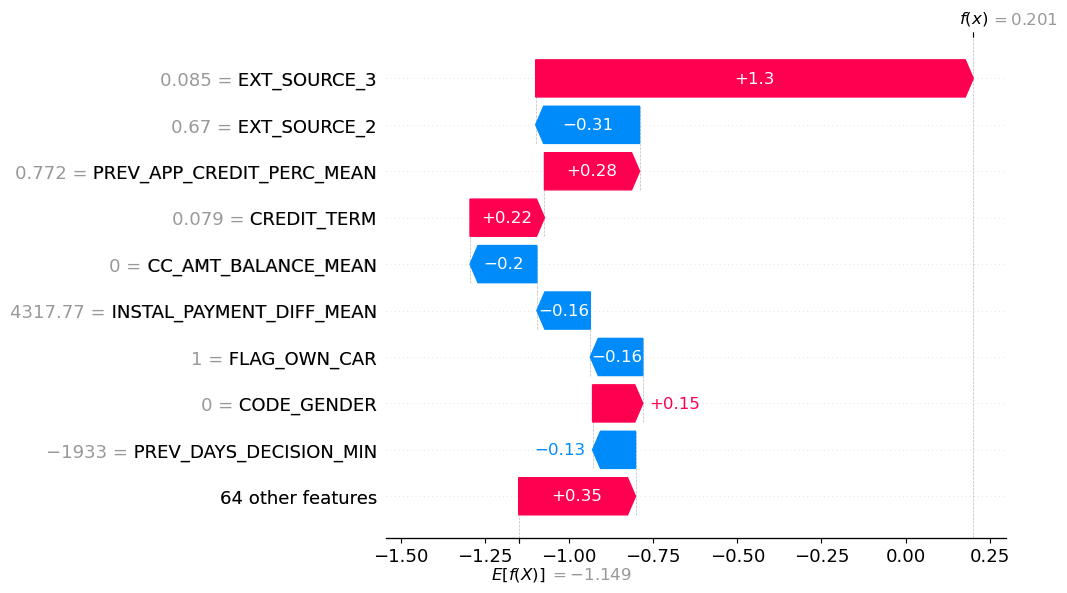

In [206]:
# Sélection d’un client
indice_client = 458
print(f"Client sélectionné : {indice_client}")
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_to_use[indice_client],
        base_values=base_value,
        data=X_test_base.iloc[indice_client],
        feature_names=X_test_base.columns
    )
)


## Pipeline


🔎 Seuil appliqué : 0.50
🎯 Coût métier = 53994
✅ F1-score = 0.1345
✅ Précision = 0.0781
✅ Rappel = 0.4840
✅ ROC AUC = 0.4911
✅ Accuracy = 0.4970
1.0    30777
0.0    30725
Name: count, dtype: int64


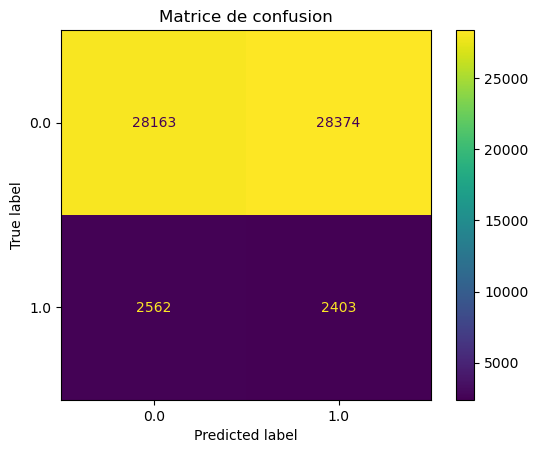

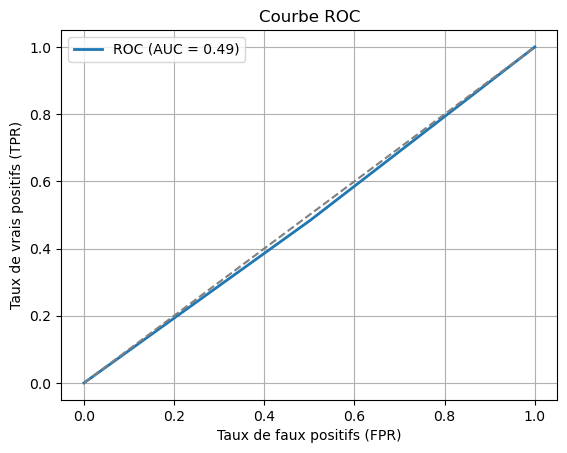

In [39]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline


# Liste des variables numériques
numerical_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS','CNT_CHILDREN',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'BURO_DAYS_CREDIT_MEAN', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'BURO_CREDIT_DAY_OVERDUE_MEAN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_APPLICATION_MEAN', 'PREV_APP_CREDIT_PERC_MEAN',
    'PREV_DAYS_DECISION_MIN', 'POS_SK_DPD_MEAN', 'POS_SK_DPD_DEF_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN', 'INSTAL_PAYMENT_DIFF_MAX',
    'INSTAL_DPD_MEAN', 'CC_AMT_BALANCE_MEAN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN', 'CC_SK_DPD_MAX', 'DAYS_EMPLOYED_PERC',
    'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'CREDIT_TERM', 'AGE']


# Pipeline baseline (dummy) ImbPipeline pour SMOTE
baseline_pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DummyClassifier(strategy='stratified', random_state=42))
])

# Fit / Predict
baseline_pipeline.fit(X_train_base, y_train_split)
y_proba_dummy = baseline_pipeline.predict_proba(X_val_base)[:, 1] #proba qu'obs soit classe 1
y_pred_dummy = baseline_pipeline.predict(X_val_base)

# Évaluation
metrics_050_dummy= evaluate_model(y_val_split, y_pred_dummy, y_proba_dummy, threshold=0.5)
plot_roc(y_val_split, y_proba_dummy)

C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔎 Seuil appliqué : 0.50
🎯 Coût métier = 49650
✅ F1-score = 0.0000
✅ Précision = 0.0000
✅ Rappel = 0.0000
✅ ROC AUC = 0.5000
✅ Accuracy = 0.9193
0.0    61502
Name: count, dtype: int64


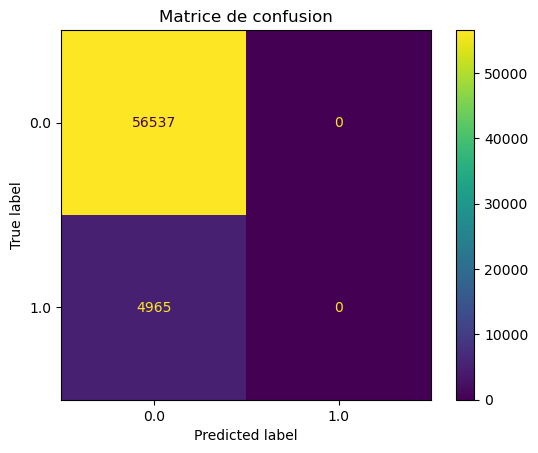

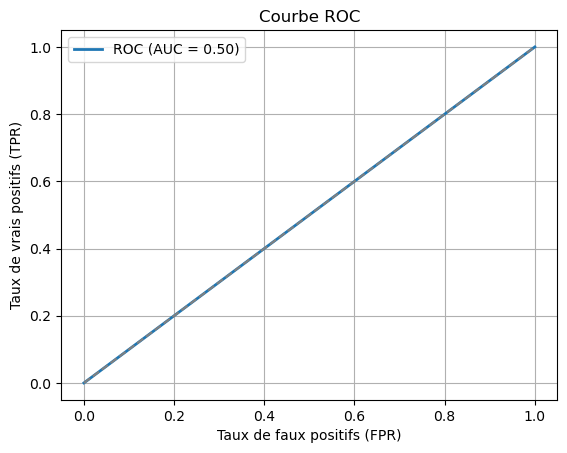

In [51]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline


# Liste des variables numériques
numerical_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS','CNT_CHILDREN',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'BURO_DAYS_CREDIT_MEAN', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'BURO_CREDIT_DAY_OVERDUE_MEAN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_APPLICATION_MEAN', 'PREV_APP_CREDIT_PERC_MEAN',
    'PREV_DAYS_DECISION_MIN', 'POS_SK_DPD_MEAN', 'POS_SK_DPD_DEF_MEAN', 'INSTAL_PAYMENT_DIFF_MEAN', 'INSTAL_PAYMENT_DIFF_MAX',
    'INSTAL_DPD_MEAN', 'CC_AMT_BALANCE_MEAN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN', 'CC_SK_DPD_MAX', 'DAYS_EMPLOYED_PERC',
    'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'CREDIT_TERM', 'AGE']


# Pipeline baseline (dummy)
baseline_pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))
])

# Fit / Predict
baseline_pipeline.fit(X_train_base, y_train_split)
y_proba_dummy = baseline_pipeline.predict_proba(X_val_base)[:, 1]
y_pred_dummy = baseline_pipeline.predict(X_val_base)

# Évaluation
metrics_050_dummy= evaluate_model(y_val_split, y_pred_dummy, y_proba_dummy, threshold=0.5)
plot_roc(y_val_split, y_proba_dummy)


🔎 Seuil appliqué : 0.50
🎯 Coût métier = 39900
✅ F1-score = 0.2172
✅ Précision = 0.1360
✅ Rappel = 0.5384
✅ ROC AUC = 0.6568
✅ Accuracy = 0.6866
0    41849
1    19653
Name: count, dtype: int64


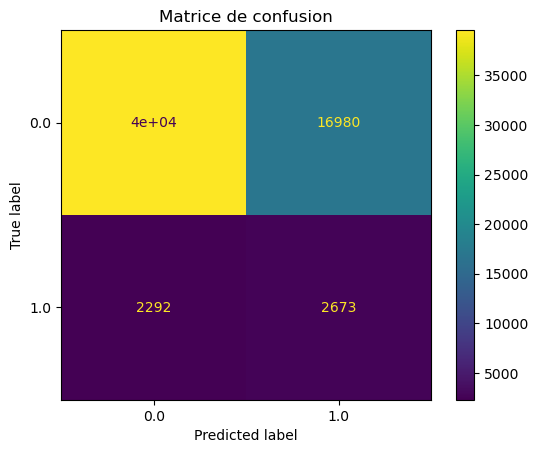


🔎 Seuil appliqué : 0.60
🎯 Coût métier = 39656
✅ F1-score = 0.2211
✅ Précision = 0.1406
✅ Rappel = 0.5180
✅ ROC AUC = 0.6568
✅ Accuracy = 0.7054
0    43204
1    18298
Name: count, dtype: int64


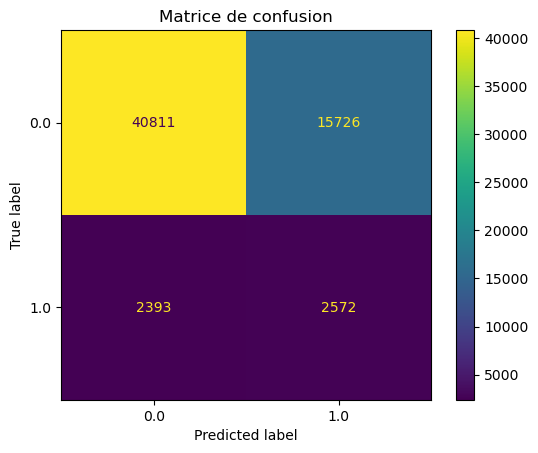

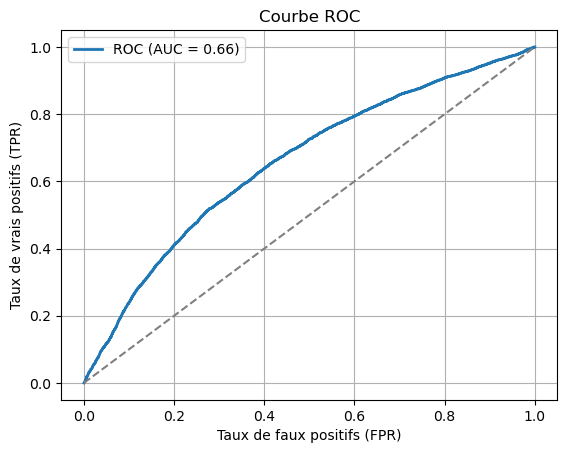

In [53]:
# Pipeline avec SMOTE
gnb_pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GaussianNB())
])

# Entraînement
gnb_pipeline.fit(X_train_base, y_train_split)

# Évaluation
y_val_proba_gnb = gnb_pipeline.predict_proba(X_val_base)[:, 1]

# Prédictions au seuil 0.50 (standard)
y_val_pred_050_gnb = (y_val_proba_gnb >= 0.5).astype(int) # mon .predict manuel
metrics_050_gnb= evaluate_model(y_val_split, y_val_pred_050_gnb, y_val_proba_gnb, threshold=0.5)

# Recherche du seuil optimal
threshold_opt_gnb = find_optimal_threshold(y_val_split, y_val_proba_gnb)

# Prédictions au seuil optimal
y_val_pred_gnb = (y_val_proba_gnb >= threshold_opt_gnb).astype(int)
metrics_gnb = evaluate_model(y_val_split, y_val_pred_gnb, y_val_proba_gnb, threshold=threshold_opt_gnb)
plot_roc(y_val_split, y_val_proba_gnb)


C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🔎 Seuil appliqué : 0.50
🎯 Coût métier = 33343
✅ F1-score = 0.2628
✅ Précision = 0.1632
✅ Rappel = 0.6741
✅ ROC AUC = 0.7484
✅ Accuracy = 0.6946
0    40992
1    20510
Name: count, dtype: int64


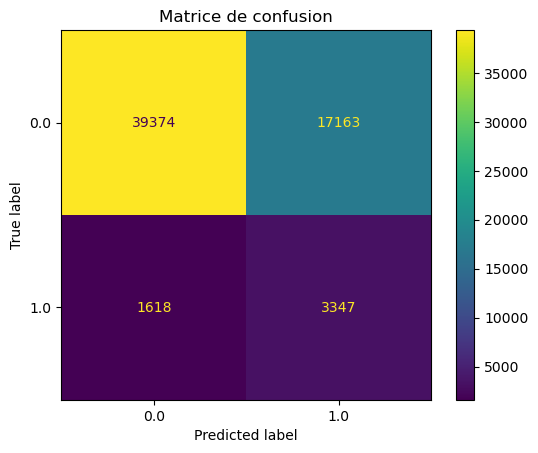


🔎 Seuil appliqué : 0.50
🎯 Coût métier = 33343
✅ F1-score = 0.2628
✅ Précision = 0.1632
✅ Rappel = 0.6741
✅ ROC AUC = 0.7484
✅ Accuracy = 0.6946
0    40992
1    20510
Name: count, dtype: int64


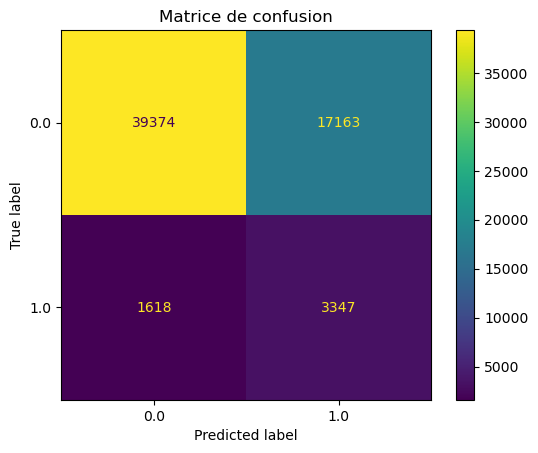

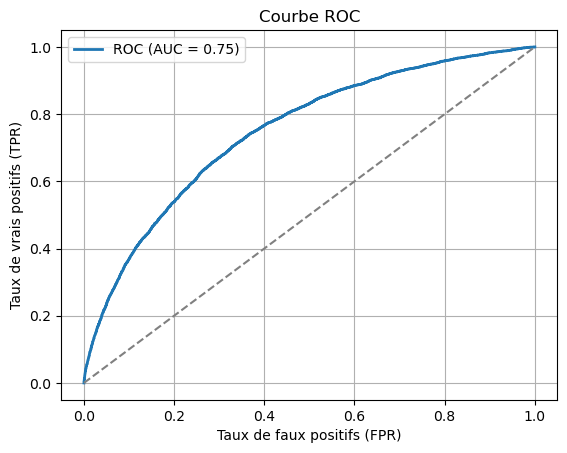

In [55]:
# Pipeline avec SMOTE
logistic_pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='saga', class_weight='balanced', C= 0.50, penalty= "l2", random_state=42))
])

# Entraînement
logistic_pipeline.fit(X_train_base, y_train_split)

# Prédictions
y_val_proba_lr = logistic_pipeline.predict_proba(X_val_base)[:, 1]
y_val_pred_050_lr = (y_val_proba_lr >= 0.5).astype(int)
metrics_050_lr= evaluate_model(y_val_split, y_val_pred_050_lr, y_val_proba_lr, threshold =0.50)

# Seuil optimal
threshold_opt_lr = find_optimal_threshold(y_val_split, y_val_proba_lr)
y_val_pred_opt_lr = (y_val_proba_lr >= threshold_opt_lr).astype(int)
metrics_opt_lr= evaluate_model(y_val_split, y_val_pred_opt_lr, y_val_proba_lr, threshold=threshold_opt_lr)

plot_roc(y_val_split, y_val_proba_lr)

C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔎 Seuil appliqué : 0.50
🎯 Coût métier = 48143
✅ F1-score = 0.0621
✅ Précision = 0.5699
✅ Rappel = 0.0328
✅ ROC AUC = 0.7718
✅ Accuracy = 0.9199
0    61216
1      286
Name: count, dtype: int64


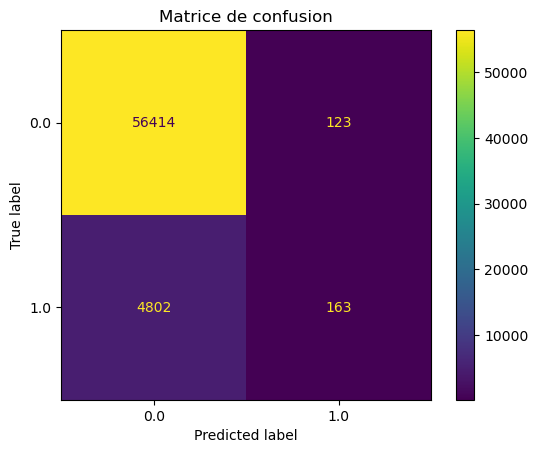


🔎 Seuil appliqué : 0.10
🎯 Coût métier = 31227
✅ F1-score = 0.2950
✅ Précision = 0.1915
✅ Rappel = 0.6421
✅ ROC AUC = 0.7718
✅ Accuracy = 0.7523
0    44857
1    16645
Name: count, dtype: int64


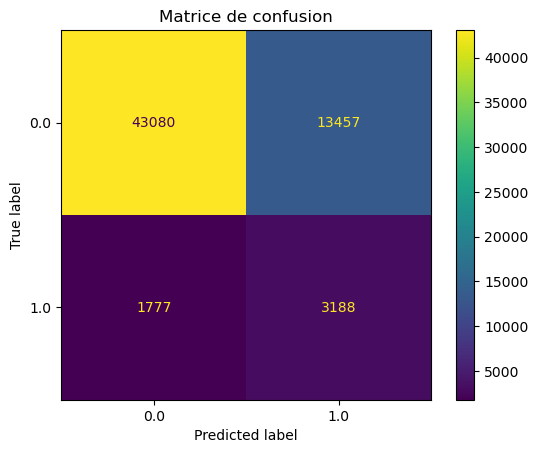

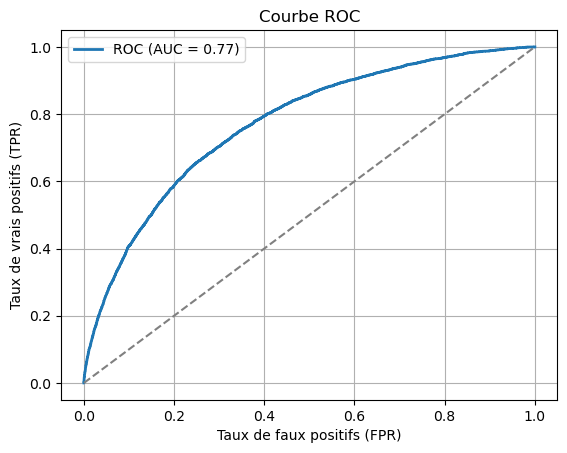

In [57]:
pipe_lgbm = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LGBMClassifier(
        learning_rate=0.11114350653481823,
        num_leaves=150,
        max_depth=12,
        min_child_samples=100,
        subsample=0.5,
        colsample_bytree=0.5,
        reg_alpha=1.0,
        reg_lambda=1.0,
        scale_pos_weight=1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ))
])
pipe_lgbm.fit(X_train_base, y_train_split)

y_val_proba_lgbm = pipe_lgbm.predict_proba(X_val_base)[:, 1]
y_val_pred_050= (y_val_proba_lgbm >=0.5).astype(int)
metrics_050_lgbm= evaluate_model(y_val_split, y_val_pred_050, y_val_proba_lgbm, threshold=0.5)

threshold_opt_lgbm = find_optimal_threshold(y_val_split, y_val_proba_lgbm)
y_val_pred_opt_lgbm = (y_val_proba_lgbm >= threshold_opt_lgbm).astype(int)
metrics_opt_lgbm=evaluate_model(y_val_split, y_val_pred_opt_lgbm, y_val_proba_lgbm, threshold=threshold_opt_lgbm)
plot_roc(y_val_split, y_val_proba_lgbm)


# Avertissement car tableau numpy sans nom des feature à cause du passage de SMOTE dans la pipeline et le LightGBM attend un df mais n'a pas d'impact sur le perf


🔎 Seuil appliqué : 0.50
🎯 Coût métier = 49502
✅ F1-score = 0.0064
✅ Précision = 0.5714
✅ Rappel = 0.0032
✅ ROC AUC = 0.7334
✅ Accuracy = 0.9193
0    61474
1       28
Name: count, dtype: int64


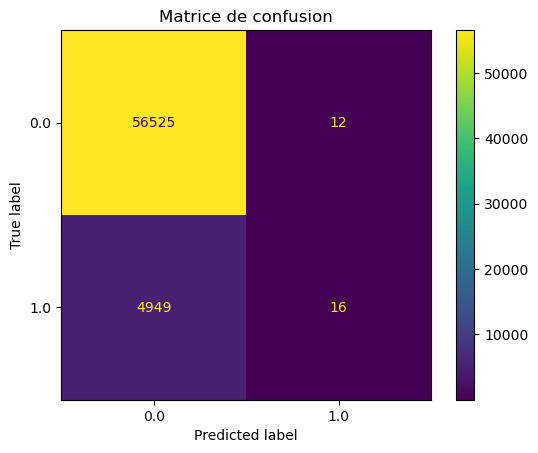


🔎 Seuil appliqué : 0.15
🎯 Coût métier = 34278
✅ F1-score = 0.2663
✅ Précision = 0.1711
✅ Rappel = 0.6006
✅ ROC AUC = 0.7334
✅ Accuracy = 0.7328
0    44072
1    17430
Name: count, dtype: int64


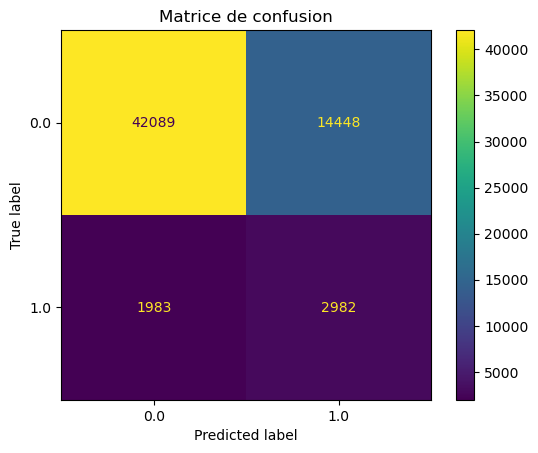

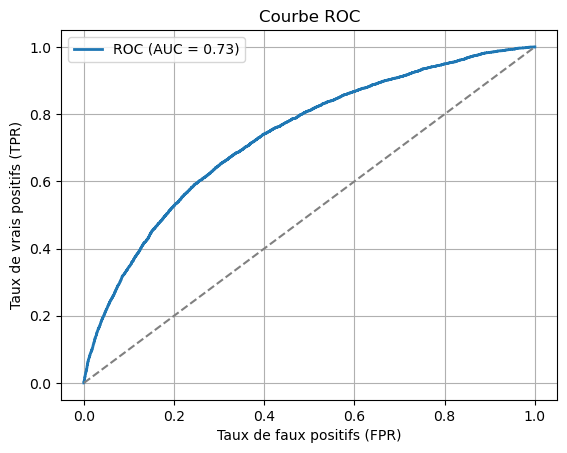

In [59]:
pipe_rf = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(
        n_estimators=759,
        max_depth=27,
        min_samples_split=4,
        max_features='log2',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

pipe_rf.fit(X_train_base, y_train_split)

y_val_proba_rf = pipe_rf.predict_proba(X_val_base)[:, 1]
y_val_pred_050 = (y_val_proba_rf >=0.5).astype(int)
metrics_050_rf=evaluate_model(y_val_split, y_val_pred_050, y_val_proba_rf, threshold=0.50)
threshold_opt_rf = find_optimal_threshold(y_val_split, y_val_proba_rf)
y_val_pred_opt_rf = (y_val_proba_rf >= threshold_opt_rf).astype(int)
metrics_opt_rf=evaluate_model(y_val_split, y_val_pred_opt_rf, y_val_proba_rf, threshold=threshold_opt_rf)
plot_roc(y_val_split, y_val_proba_rf)

# Lancement MLFLOW

*Dans le terminal:*
- activer l'environnement: conda activate scoring-env
- aller dans le bon chemin : cd...
- activer mlflow: mlflow ui

- mlflow ui => uniquement l’interface graphique (UI), sans accès aux artefacts ni aux alias de modèle depuis une API externe.

- mlflow server => démarre le tracking server complet, nécessaire pour que l'API puisse accéder aux modèles via l’alias et gérer les artefacts pour le déploiement sur le cloud

mlflow server --backend-store-uri sqlite:///mlflow/mlflow.db --default-artifact-root ./mlflow/artifact --host 0.0.0.0 --port 5000 --serve-artifacts

- L’input_example est un exemple concret de donnée d'entrée passée au modèle pour aider MLflow à comprendre ce à quoi ressemblent vos inputs (structure, colonnes, types),
- La signature du modèle décrit la forme attendue des entrées et des sorties : les types, dimensions, colonnes.

### Model Tracking + registry

In [61]:
# Définir l'URI de suivi
mlflow.set_tracking_uri('http://localhost:5000')  # Serveur MLflow

In [63]:
import mlflow
from mlflow.models.signature import infer_signature

def log_model_to_mlflow(run_name, model_name, model, params, metrics, y_true,
                        y_pred, threshold, input_example=None, signature=None, register_model=False):
    """
    Enregistre un modèle ML et ses artefacts dans MLflow.

    Args:
        run_name (str): Nom du run dans MLflow.
        model_name (str): Nom du modèle
        model (sklearn Pipeline): Pipeline entraîné à logguer.
        params (dict): Paramètres à logguer (hyperparams).
        metrics (dict): Dictionnaire de métriques.
        y_true (array): Valeurs vraies.
        y_pred (array): Prédictions binaires du modèle.
        threshold (float): Seuil de décision utilisé pour y_pred.
        input_example: Exemple d’entrée.
        signature (mlflow.models.signature, optional): Signature du modèle.
        register_model (bool): Si True, ajoute au Model Registry.
    """

    with mlflow.start_run(run_name=run_name): # tout ce qui est loggué sera rattaché à ce run_name
        
        # === PARAMS ===
        mlflow.log_param("threshold", threshold) # log_param : Enregistre un paramètre unique (clé-valeur) dans MLflow.
        mlflow.log_param("model_name", model.__class__.__name__)
        mlflow.log_params(params)

        # === METRICS ===
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name, value)

        # === MODEL ===
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            input_example=input_example,
            signature=signature,
            serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE,
            registered_model_name=model_name if register_model else None  # vers Model Registry si demandé
        )

        # === CONFUSION MATRIX ===
        fig, ax = plt.subplots()
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
        plt.title(f"Confusion Matrix - {model_name} (th={threshold:.2f})")
        fig_path = f"{run_name}_conf_matrix.png"
        fig.savefig(fig_path)
        mlflow.log_artifact(fig_path)
        plt.close()
        os.remove(fig_path)  # suppression de l'image locale pour espace

        print(f"✅ MLflow logging terminé pour : {run_name}")


In [65]:
# 1. Dummy classifier

# Paramètres du modèle
params_dummy = baseline_pipeline.named_steps["classifier"].get_params()

# Signature pour MLflow
signature = infer_signature(X_val_base, y_pred_dummy)

# === Logging VERSION 1 : seuil 0.5
log_model_to_mlflow(
    run_name="DummyClassifier_Threshold_0.5",
    model_name="DummyClassifier",
    model=baseline_pipeline,
    params=params_dummy,
    metrics=metrics_050_dummy,
    y_true=y_val_split,
    y_pred=y_pred_dummy,
    threshold=0.5,
    input_example=X_val_base.iloc[:5],
    signature=signature,
    register_model=True  # Enregistre dans le Model Registry
)

# Pas de version 2 car pas d'optimisation du seuil 


Successfully registered model 'DummyClassifier'.
2025/05/10 23:07:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier, version 1
Created version '1' of model 'DummyClassifier'.


✅ MLflow logging terminé pour : DummyClassifier_Threshold_0.5
🏃 View run DummyClassifier_Threshold_0.5 at: http://localhost:5000/#/experiments/0/runs/f7aae7b945874d599d8d40b4c0f4b283
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [67]:
# 2. Naives Bayes

# Paramètres du modèle
params_gnb = gnb_pipeline.named_steps["classifier"].get_params()

# === Logging VERSION 1 : seuil 0.5
log_model_to_mlflow(
    run_name="NaivesBayes_Threshold_Base",
    model_name="NaivesBayes",
    model=gnb_pipeline,
    params=params_gnb,
    metrics=metrics_050_gnb,
    y_true=y_val_split,
    y_pred=y_val_pred_050_gnb,
    threshold=0.5,
    input_example=X_val_base.iloc[:5],
    signature=infer_signature(X_val_base, y_val_pred_050_gnb),
    register_model=True  # Enregistre dans le Model Registry
)


# === Logging VERSION 2 : seuil optimal

log_model_to_mlflow(
    run_name="NaivesBayes_Threshold_Optimal",
    model_name="NaivesBayes",
    model=gnb_pipeline,
    params=params_gnb,
    metrics=metrics_gnb,
    y_true=y_val_split,
    y_pred=y_val_pred_gnb,
    threshold=threshold_opt_gnb,
    register_model=True ,
    input_example=X_val_base.iloc[:1],
    signature=infer_signature(X_val_base, y_val_pred_gnb)
)



Successfully registered model 'NaivesBayes'.
2025/05/10 23:08:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: NaivesBayes, version 1
Created version '1' of model 'NaivesBayes'.


✅ MLflow logging terminé pour : NaivesBayes_Threshold_Base
🏃 View run NaivesBayes_Threshold_Base at: http://localhost:5000/#/experiments/0/runs/93c086fac6584a2f9fbeb2a8e370f5cd
🧪 View experiment at: http://localhost:5000/#/experiments/0


Registered model 'NaivesBayes' already exists. Creating a new version of this model...
2025/05/10 23:08:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: NaivesBayes, version 2
Created version '2' of model 'NaivesBayes'.


✅ MLflow logging terminé pour : NaivesBayes_Threshold_Optimal
🏃 View run NaivesBayes_Threshold_Optimal at: http://localhost:5000/#/experiments/0/runs/a815086a5d994989a307d399f224284f
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [68]:
# Logistic regression

# Paramètres du modèle
params_lr = logistic_pipeline.named_steps["classifier"].get_params()

# === Logging VERSION 1 : seuil 0.5
log_model_to_mlflow(
    run_name="LogisticRegression_Threshold_050",
    model_name="LogisticRegression",
    model=logistic_pipeline,
    params=params_lr,
    metrics=metrics_050_lr,
    y_true=y_val_split,
    y_pred=y_val_pred_050_lr,
    threshold=0.5,
    input_example=X_val_base.iloc[:5],
    signature=infer_signature(X_val_base, y_val_pred_050_lr),
    register_model=True  # Enregistre dans le Model Registry
)


# === Logging VERSION 2 : seuil optimal

log_model_to_mlflow(
    run_name="LogisticRegression_Threshold_Optimal",
    model_name="LogisticRegression",
    model=logistic_pipeline,
    params=params_lr,
    metrics=metrics_opt_lr,
    y_true=y_val_split,
    y_pred=y_val_pred_opt_lr,
    threshold=threshold_opt_lr,
    register_model=True,
    input_example=X_val_base.iloc[:1],
    signature=infer_signature(X_val_base, y_val_pred_opt_lr)
)

Successfully registered model 'LogisticRegression'.
2025/05/10 23:09:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 1
Created version '1' of model 'LogisticRegression'.


✅ MLflow logging terminé pour : LogisticRegression_Threshold_050
🏃 View run LogisticRegression_Threshold_050 at: http://localhost:5000/#/experiments/0/runs/57521c414f5647de991aa5fc85d1d41e
🧪 View experiment at: http://localhost:5000/#/experiments/0


Registered model 'LogisticRegression' already exists. Creating a new version of this model...
2025/05/10 23:09:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression, version 2
Created version '2' of model 'LogisticRegression'.


✅ MLflow logging terminé pour : LogisticRegression_Threshold_Optimal
🏃 View run LogisticRegression_Threshold_Optimal at: http://localhost:5000/#/experiments/0/runs/70e2c7eee20a4f618b5a5c816824a81b
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [69]:
# Paramètres du modèle
params_lgbm = pipe_lgbm.named_steps["classifier"].get_params()

# === Logging VERSION 1 : seuil 0.5
log_model_to_mlflow(
    run_name="LightGBM_THRESHOLD_050",
    model_name="LightGBM",
    model=pipe_lgbm,
    params=params_lgbm,
    metrics=metrics_050_lgbm,
    y_true=y_val_split,
    y_pred=y_val_pred_050,
    threshold=0.5,
    input_example=X_val_base.iloc[:5],
    signature=infer_signature(X_val_base, y_val_pred_050),
    register_model=True  # Enregistre dans le Model Registry
)


# === Logging VERSION 2 : seuil optimal

log_model_to_mlflow(
    run_name="LightGBM_THRESHOLD_Optimal",
    model_name="LightGBM",
    model=pipe_lgbm,
    params=params_lgbm,
    metrics=metrics_opt_lgbm,
    y_true=y_val_split,
    y_pred=y_val_pred_opt_lgbm,
    threshold=threshold_opt_lgbm,
    register_model=True,
    input_example=X_val_base.iloc[:1],
    signature=infer_signature(X_val_base, y_val_pred_opt_lgbm)
)


C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Successfully registered model 'LightGBM'.
2025/05/10 23:09:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 1
Created version '1' of model 'LightGBM'.


✅ MLflow logging terminé pour : LightGBM_THRESHOLD_050
🏃 View run LightGBM_THRESHOLD_050 at: http://localhost:5000/#/experiments/0/runs/c7cea3dc22994426befd9afac0e27962
🧪 View experiment at: http://localhost:5000/#/experiments/0


C:\Users\alaro\anaconda3\envs\scoring-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Registered model 'LightGBM' already exists. Creating a new version of this model...
2025/05/10 23:10:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 2
Created version '2' of model 'LightGBM'.


✅ MLflow logging terminé pour : LightGBM_THRESHOLD_Optimal
🏃 View run LightGBM_THRESHOLD_Optimal at: http://localhost:5000/#/experiments/0/runs/f583cd39d0a34f1a8709f3685b84795b
🧪 View experiment at: http://localhost:5000/#/experiments/0


Le modèle randomForest n'arrive pas à se logguer à cause de sa taille trop élevé puisque ce n'est pas le modèle final sélectionné nous ne le loguerons pas. 

In [ ]:
# Paramètres du modèle
params_rf = pipe_rf.named_steps["classifier"].get_params()

# === Logging VERSION 1 : seuil 0.5
log_model_to_mlflow(
    run_name="RandomForest_Threshold_050",
    model_name="RandomForest",
    model=pipe_rf,
    params=params_rf,
    metrics=metrics_050_rf,
    y_true=y_val_split,
    y_pred=y_val_pred_050,
    threshold=0.5,
    input_example=X_val_base.iloc[:5],
    signature=infer_signature(X_val_base, y_val_pred_050),
    register_model=True  # Enregistre dans le Model Registry
)


# === Logging VERSION 2 : seuil optimal

log_model_to_mlflow(
    run_name="RandomForest_Threshold_base",
    model_name="RandomForest",
    model=pipe_rf,
    params=params_rf,
    metrics=metrics_opt_rf,
    y_true=y_val_split,
    y_pred=y_val_pred_opt_rf,
    threshold=threshold_opt_rf,
    register_model=True,
    input_example=X_val_base.iloc[:1],
    signature=infer_signature(X_val_base, y_val_pred_opt_rf)
)

# Test API

Pour activer l'API: 
- nouvel onglet terminal => activate environnement + cd  api
- uvicorn app:app --reload   (nom_du_fichier:app)

- pour visualier l'API: http://localhost:8000/docs


In [182]:
pd.set_option('display.max_columns', 100)     
display(X_val_base.iloc[:1])

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BUILD_AVG,TOTALAREA_MODE,DEF_60_CNT_SOCIAL_CIRCLE,IS_UNEMPLOYED,BURO_DAYS_CREDIT_MEAN,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_CREDIT_DAY_OVERDUE_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_APPLICATION_MEAN,PREV_APP_CREDIT_PERC_MEAN,PREV_DAYS_DECISION_MIN,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MEAN,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_MAX,INSTAL_DPD_MEAN,CC_AMT_BALANCE_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_SK_DPD_MAX,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,CREDIT_TERM,AGE,NAME_CONTRACT_TYPE_Revolving loans,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,SECTOR_Industry,SECTOR_Trade,SECTOR_Transport,SECTOR_Business Entity,SECTOR_Government,SECTOR_Security,SECTOR_Services,SECTOR_Construction,SECTOR_Medicine,SECTOR_Police,SECTOR_Other,OCCUPATION_Labor_Work,OCCUPATION_Sales_Services,OCCUPATION_Medical_Staff,OCCUPATION_Security,OCCUPATION_Management_Core,OCCUPATION_Other
180592,0.0,1.0,0.0,0.0,247500.0,497520.0,59175.0,450000.0,0.014464,2.0,2.0,0.273594,0.752981,0.535276,0.7552,0.0323,0.0,0.0,-1050.571429,195504.852273,0.0,0.0,138186.0,141840.0,1.026443,-1550.0,0.0,0.0,0.0,0.0,0.0,26793.606316,4093.971864,0.0,0.011957,123750.0,0.239091,0.11894,0.11894,53.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Test API en local

In [6]:
import requests
import json

url = " http://localhost:8000//predict"

data = {
    "CODE_GENDER": 0.0,
    "FLAG_OWN_CAR": 1.0,
    "FLAG_OWN_REALTY": 0.0,
    "CNT_CHILDREN": 0.0,
    "AMT_INCOME_TOTAL": 247500.0,
    "AMT_CREDIT": 497520.0,
    "AMT_ANNUITY": 59175.0,
    "AMT_GOODS_PRICE": 450000.0,
    "REGION_POPULATION_RELATIVE": 0.014464,
    "CNT_FAM_MEMBERS": 2.0,
    "REGION_RATING_CLIENT_W_CITY": 2.0,
    "EXT_SOURCE_1": 0.273594,
    "EXT_SOURCE_2": 0.752981,
    "EXT_SOURCE_3": 0.535276,
    "YEARS_BUILD_AVG": 0.7552,
    "TOTALAREA_MODE": 0.0323,
    "DEF_60_CNT_SOCIAL_CIRCLE": 0.0,
    "IS_UNEMPLOYED": 0.0,
    "BURO_DAYS_CREDIT_MEAN": -1050.571429,
    "BURO_AMT_CREDIT_SUM_MEAN": 195504.852273,
    "BURO_AMT_CREDIT_SUM_OVERDUE_MEAN": 0.0,
    "BURO_CREDIT_DAY_OVERDUE_MEAN": 0.0,
    "PREV_AMT_CREDIT_MAX": 138186.0,
    "PREV_AMT_APPLICATION_MEAN": 141840.0,
    "PREV_APP_CREDIT_PERC_MEAN": 1.026443,
    "PREV_DAYS_DECISION_MIN": -1550.0,
    "POS_SK_DPD_MEAN": 0.0,
    "POS_SK_DPD_DEF_MEAN": 0.0,
    "INSTAL_PAYMENT_DIFF_MEAN": 0.0,
    "INSTAL_PAYMENT_DIFF_MAX": 0.0,
    "INSTAL_DPD_MEAN": 0.0,
    "CC_AMT_BALANCE_MEAN": 26793.606316,
    "CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN": 4093.971864,
    "CC_SK_DPD_MAX": 0.0,
    "DAYS_EMPLOYED_PERC": 0.011957,
    "INCOME_PER_PERSON": 123750.0,
    "ANNUITY_INCOME_PERC": 0.239091,
    "PAYMENT_RATE": 0.11894,
    "CREDIT_TERM": 0.11894,
    "AGE": 53.0,
    "NAME_CONTRACT_TYPE_Revolving loans": 0.0,
    "NAME_INCOME_TYPE_Commercial associate": 0.0,
    "NAME_EDUCATION_TYPE_Secondary / secondary special": 0.0,
    "NAME_HOUSING_TYPE_House / apartment": 0.0,
    "NAME_INCOME_TYPE_Pensioner": 0.0,
    "NAME_INCOME_TYPE_State servant": 1.0,
    "NAME_INCOME_TYPE_Unemployed": 0.0,
    "NAME_INCOME_TYPE_Working": 0.0,
    "NAME_EDUCATION_TYPE_Higher education": 1.0,
    "NAME_EDUCATION_TYPE_Lower secondary": 1.0,
    "NAME_FAMILY_STATUS_Married": 0.0,
    "NAME_FAMILY_STATUS_Single / not married": 0.0,
    "NAME_FAMILY_STATUS_Widow": 1.0,
    "NAME_HOUSING_TYPE_Office apartment": 0.0,
    "NAME_HOUSING_TYPE_Rented apartment": 0.0,
    "NAME_HOUSING_TYPE_With parents": 0.0,
    "SECTOR_Industry": 0.0,
    "SECTOR_Trade": 0.0,
    "SECTOR_Transport": 0.0,
    "SECTOR_Business Entity": 1.0,
    "SECTOR_Government": 0.0,
    "SECTOR_Security": 0.0,
    "SECTOR_Services": 0.0,
    "SECTOR_Construction": 0.0,
    "SECTOR_Medicine": 0.0,
    "SECTOR_Police": 0.0,
    "SECTOR_Other": 0.0,
    "OCCUPATION_Labor_Work": 0.0,
    "OCCUPATION_Sales_Services": 0.0,
    "OCCUPATION_Medical_Staff": 0.0,
    "OCCUPATION_Security": 0.0,
    "OCCUPATION_Management_Core": 0.0,
    "OCCUPATION_Other": 1.0
}

response = requests.post(url, json=data)

print("Statut HTTP:", response.status_code)
print("Réponse JSON:", response.json())



Statut HTTP: 200
Réponse JSON: {'proba': 0.0, 'décision': 'accepté'}


In [116]:
id_value = 180592

# Filtrage de la ligne correspondante
target_value = df_train.loc[df_train['SK_ID_CURR'] == id_value, 'TARGET']

# Affichage du résultat
print(f"Valeur cible pour l'ID {id_value} : {target_value.values[0]}")


Valeur cible pour l'ID 180592 : 0


### Test API serveur

In [11]:
import requests
import json

url = "https://projet-7-scoring-credit.onrender.com/predict"

data = {
    "CODE_GENDER": 0.0,
    "FLAG_OWN_CAR": 1.0,
    "FLAG_OWN_REALTY": 0.0,
    "CNT_CHILDREN": 0.0,
    "AMT_INCOME_TOTAL": 247500.0,
    "AMT_CREDIT": 497520.0,
    "AMT_ANNUITY": 59175.0,
    "AMT_GOODS_PRICE": 450000.0,
    "REGION_POPULATION_RELATIVE": 0.014464,
    "CNT_FAM_MEMBERS": 2.0,
    "REGION_RATING_CLIENT_W_CITY": 2.0,
    "EXT_SOURCE_1": 0.273594,
    "EXT_SOURCE_2": 0.752981,
    "EXT_SOURCE_3": 0.535276,
    "YEARS_BUILD_AVG": 0.7552,
    "TOTALAREA_MODE": 0.0323,
    "DEF_60_CNT_SOCIAL_CIRCLE": 0.0,
    "IS_UNEMPLOYED": 0.0,
    "BURO_DAYS_CREDIT_MEAN": -1050.571429,
    "BURO_AMT_CREDIT_SUM_MEAN": 195504.852273,
    "BURO_AMT_CREDIT_SUM_OVERDUE_MEAN": 0.0,
    "BURO_CREDIT_DAY_OVERDUE_MEAN": 0.0,
    "PREV_AMT_CREDIT_MAX": 138186.0,
    "PREV_AMT_APPLICATION_MEAN": 141840.0,
    "PREV_APP_CREDIT_PERC_MEAN": 1.026443,
    "PREV_DAYS_DECISION_MIN": -1550.0,
    "POS_SK_DPD_MEAN": 0.0,
    "POS_SK_DPD_DEF_MEAN": 0.0,
    "INSTAL_PAYMENT_DIFF_MEAN": 0.0,
    "INSTAL_PAYMENT_DIFF_MAX": 0.0,
    "INSTAL_DPD_MEAN": 0.0,
    "CC_AMT_BALANCE_MEAN": 26793.606316,
    "CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN": 4093.971864,
    "CC_SK_DPD_MAX": 0.0,
    "DAYS_EMPLOYED_PERC": 0.011957,
    "INCOME_PER_PERSON": 123750.0,
    "ANNUITY_INCOME_PERC": 0.239091,
    "PAYMENT_RATE": 0.11894,
    "CREDIT_TERM": 0.11894,
    "AGE": 53.0,
    "NAME_CONTRACT_TYPE_Revolving loans": 0.0,
    "NAME_INCOME_TYPE_Commercial associate": 0.0,
    "NAME_EDUCATION_TYPE_Secondary / secondary special": 0.0,
    "NAME_HOUSING_TYPE_House / apartment": 0.0,
    "NAME_INCOME_TYPE_Pensioner": 0.0,
    "NAME_INCOME_TYPE_State servant": 1.0,
    "NAME_INCOME_TYPE_Unemployed": 0.0,
    "NAME_INCOME_TYPE_Working": 0.0,
    "NAME_EDUCATION_TYPE_Higher education": 1.0,
    "NAME_EDUCATION_TYPE_Lower secondary": 1.0,
    "NAME_FAMILY_STATUS_Married": 0.0,
    "NAME_FAMILY_STATUS_Single / not married": 0.0,
    "NAME_FAMILY_STATUS_Widow": 1.0,
    "NAME_HOUSING_TYPE_Office apartment": 0.0,
    "NAME_HOUSING_TYPE_Rented apartment": 0.0,
    "NAME_HOUSING_TYPE_With parents": 0.0,
    "SECTOR_Industry": 0.0,
    "SECTOR_Trade": 0.0,
    "SECTOR_Transport": 0.0,
    "SECTOR_Business Entity": 1.0,
    "SECTOR_Government": 0.0,
    "SECTOR_Security": 0.0,
    "SECTOR_Services": 0.0,
    "SECTOR_Construction": 0.0,
    "SECTOR_Medicine": 0.0,
    "SECTOR_Police": 0.0,
    "SECTOR_Other": 0.0,
    "OCCUPATION_Labor_Work": 0.0,
    "OCCUPATION_Sales_Services": 0.0,
    "OCCUPATION_Medical_Staff": 0.0,
    "OCCUPATION_Security": 0.0,
    "OCCUPATION_Management_Core": 0.0,
    "OCCUPATION_Other": 1.0
}

response = requests.post(url, json=data)

print("Statut HTTP:", response.status_code)
print("Réponse JSON:", response.json())

Statut HTTP: 200
Réponse JSON: {'proba': 0.0, 'décision': 'accepté'}


# Interface streamlit

Nouvel onglet terminal: activate environnement, cd bon dossier

- streamlit run streamlit_app.py
01


- Local URL: http://localhost:8501

- Network URL: http://192.168.1.11:8501

# Pytests

Ici 3 tests sont effectués: 
1. test split and scale: test que les données sont bien découpées en ensembles d'entraînement et de validation, que la normalisation est effectuée correctement, que les dimensions des matrices retournées sont correctes.
2. test evaluate_model, permet de vérifier: que les valeurs retournées sont bien présentes, que les valeurs de coût sont calculées correctement, que le format du dictionnaire retourné est correct, que la valeur du seuil optimal est correcte
3. test fast_api, permet de vérifier que l'api renvoie bien une prédiction seulement en local
4. En déploiement automatique GithubActions ajout de test_clean_and_impute

=> création du fichier conftest pour que pytest ajoute le bon chemin dans son PYTHONPATH et qu'il puisse reconnaitre les fichiers (src et api) comme packages importables

=> Lancement (après environnemen et chemin) : pytest -s tests/ (-s pour voir toutes les sorties print etc.)


# Pousser sur Github

- cd
- git init
- git add .  ( pour ajouter tous les fichiers à part ceux de gitignore)
- git commit -m "Initial commit" (1er commit avec titre)
- git remote add origin https://github.com/Anto1293/Impl-menter-un-mod-le-de-scoring.git (direction sur Github)
- git push -u origin main (pusher sur github)

Pour nouveau commit : modification ou maj d'un fichier
- git add 'fichier'
- git commit -m "mise à jour de fichier"
- git push (nouveau push)


RENDER_DEPLOY_HOOK_URL: 
C’est un lien spécial (une URL) fourni par Render, qui déclenche un redéploiement automatique de l'application quand on y fait une requête POST